In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
#new_saver.save(sess, "../models/niger-current/model")

In [3]:
new_saver = tf.train.import_meta_graph('../models/february-fused-master-west-africa-dry/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/february-fused-master-west-africa-dry/'))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/february-fused-master-west-africa-dry/model


In [4]:
# setup function to reproject coordinates
EPSG = CRS.WGS84
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
        

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    #EXPANSION = (expansion - np.mean([distance1, distance2]))/2 # should this be 155 or 160?
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    print(after)
    #br = (br[0] + 20, br[1] + 20)
    #tl = (tl[0] - 20, tl[1] - 20)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


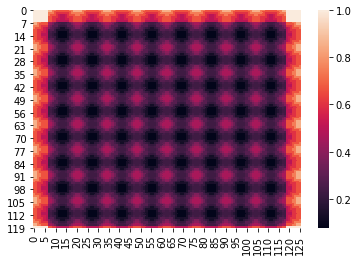

In [5]:
arr = np.array([[1, 1, 2, 2, 3, 3, 3],
                [1, 1, 2, 3, 3, 3, 3],
                [2, 2, 2, 3, 4, 4, 4],
                [2, 3, 3, 3, 4, 5, 6],
                [3, 3, 4, 4, 4, 5, 6],
                [3, 3, 4, 4, 5, 5, 6], 
                [3, 3, 4, 4, 6, 6, 6]])

#arr = np.array(
#      [[0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 1, 1, 1, 1, 1],
#       [0, 1, 2, 2, 2, 2, 2],
#       [0, 1, 2, 3, 3, 3, 3],
#       [0, 1, 2, 3, 4, 4, 4],
#       [0, 1, 2, 3, 4, 5, 5], 
#       [0, 1, 2, 3, 4, 5, 6]])

arr = arr / 6


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)



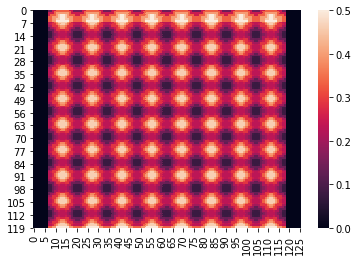

In [6]:
sns.heatmap(right_filter)

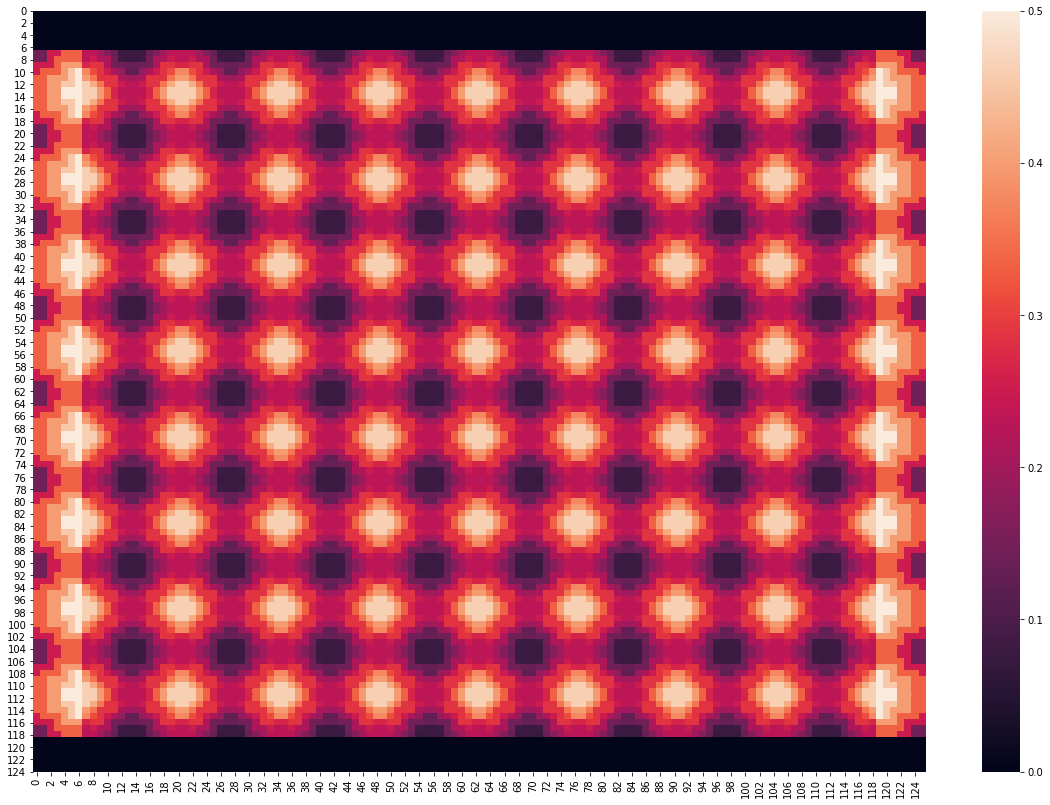

In [7]:
plt.figure(figsize=(20, 14))
sns.heatmap(up_filter)

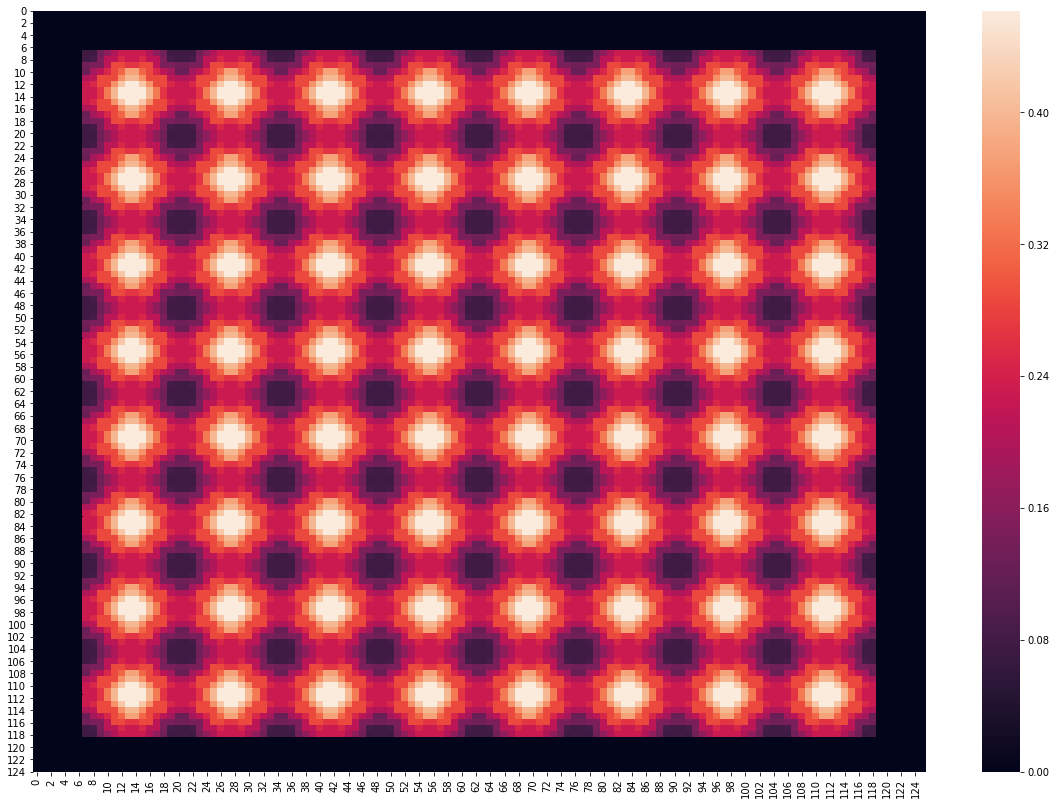

In [8]:
plt.figure(figsize=(20, 14))
sns.heatmap(upright[:, :])

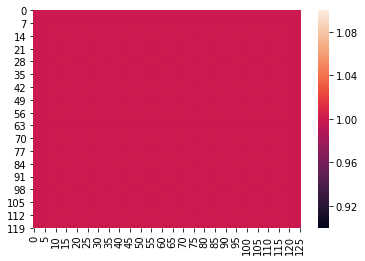

In [9]:
sum_filter = (upright + normal+right_filter + up_filter)# + right_filter + up_filter)
sns.heatmap(sum_filter)

In [10]:
np.tile(np.array(24), (24, 1)).shape

(24, 1)

In [11]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
min_all = [0.020041798930615185,
 0.037792792804539205,
 0.022476176451891663,
 0.08548464052379132,
 0.05650158278644085,
 0.07740494482219219,
 0.0840544743090868,
 0.08622615240514278,
 0.0706351237744093,
 0.0427229817584157,
 0.0,
 0.006563705061562359,
 -0.01744983049109578,
 0.005225462089292703,
  0.0063749998807907104,
 0.0001250000059371814]

max_all = [0.18134129151701867,
 0.27378561437129956,
 0.4014175131916998,
 0.4868263602256775,
 0.45080901354551306,
 0.4679806348681449,
 0.49490821748971936,
 0.5116603970527649,
 0.6328844583034514,
 0.5591901928186414,
 0.3618685007095337,
 0.697949901819229,
 0.3965708017349243,
 0.6338821130990981,
 0.815,
 0.145]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)



def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    #pred_files = ["../data/oregon/" + str(y_col) + "/" + str(folder) + "/" + str(x) + ".npy" for x in range(1, TOTAL+1)]
    pred_files = ["../tile_data/cameroon/" + str(y_col) + "/" + str(folder) + ".npy"]
    #pred_x = np.empty((0, 24, 16, 16, 14))
    pred_x = []

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        #if x.shape[0] < 24:
        #    padding = np.tile(x[-1, :, :, :], (24-x.shape[0], 1, 1, 1))
        #    x = np.concatenate((x, padding), axis = 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, 14, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)     
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, :, x]), np.max(pred_x[:, :, :, :, x]))

    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        #lengths = np.array(24).tile((batch_x.shape[0], 1))
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
        
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    #stacked = stacked / sum_filter
    return stacked

In [12]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    

In [13]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

In [14]:
x = np.load("../tile_data/cameroon/0/0.npy")






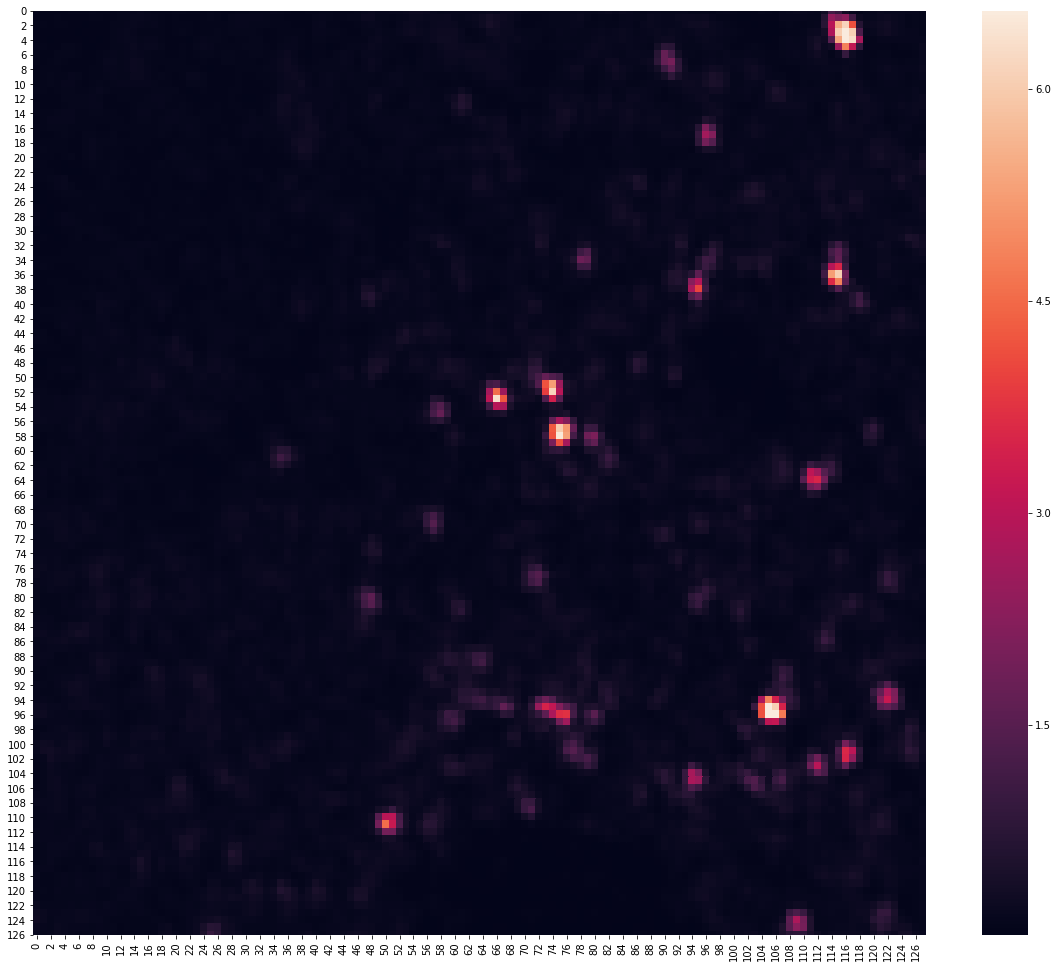

In [15]:
plt.figure(figsize=(20, 17))
sns.heatmap(x[15, :, :, 15])




In [22]:
from time import sleep
all_preds = []
for row in tnrange(0,15):
    pred_i = [load_and_predict_folder(row, col) for col in range(0, 20)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked, overalpped, up, right = load_and_predict_folder(0, 0)

In [45]:
stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 14))
#sns.heatmap(stacked)
#plt.savefig('ghana.png', dpi = 300)

<Figure size 1440x1008 with 0 Axes>

<Figure size 1440x1008 with 0 Axes>

In [46]:
thresh = 0.2 # .4, .44 for makueni, 65, 75 for kochi
thresh_p = 0.55

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        l, r, u, d =  False, False, False, False
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            if cur_window[3, 2] > thresh and cur_window[4, 2] < thresh:
                hor_vert_neighbors = True
                r = True
            if cur_window[1, 2] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                l = True
            if cur_window[2, 3] > thresh and cur_window[2, 4] < thresh:
                hor_vert_neighbors = True
                d = True
            if cur_window[2, 1] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                u = True
        passes = False
        if r and not l:
            passes = True
        if l and not r:
            passes = True
        if d and not u:
            passes = True
        if u and not d:
            passes = True
        
        if passes:
            if r:
                if cur_window[1, 1] < thresh and cur_window[1, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
            
            if l:
                if cur_window[3, 1] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if u:
                if cur_window[1, 3] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if d:
                if cur_window[1, 1] < thresh and cur_window[3, 1] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            #n_offenders = 0
                
                #print(cur_window)

Adding a tree with: 0.2910157561302186
Adding a tree with: 0.40724580734968185
Adding a tree with: 0.40832824707031257
Adding a tree with: 0.24153725306193033
Adding a tree with: 0.4615962386131287
Adding a tree with: 0.4179384052753449
Adding a tree with: 0.56
Adding a tree with: 0.5019496530294418
Adding a tree with: 0.56
Adding a tree with: 0.22052906453609467
Adding a tree with: 0.56
Adding a tree with: 0.35057386159896853
Adding a tree with: 0.22558590024709702
Adding a tree with: 0.3404729664325714
Adding a tree with: 0.56
Adding a tree with: 0.5499333341916401
Adding a tree with: 0.56
Adding a tree with: 0.4012700815995534
Adding a tree with: 0.28894729912281036
Adding a tree with: 0.45808300375938416
Adding a tree with: 0.28343652188777924
Adding a tree with: 0.2866588830947876
Adding a tree with: 0.22948408871889114
Adding a tree with: 0.56
Adding a tree with: 0.2904810681939125
Adding a tree with: 0.21928146481513977
Adding a tree with: 0.21678156405687332
Adding a tree with:

Adding a tree with: 0.2087040990591049
Adding a tree with: 0.3167349174618721
Adding a tree with: 0.56
Adding a tree with: 0.2724885685103281
Adding a tree with: 0.2948897710213294
Adding a tree with: 0.56
Adding a tree with: 0.32122635593016946
Adding a tree with: 0.23386588266917635
Adding a tree with: 0.2394586205482483
Adding a tree with: 0.56
Adding a tree with: 0.325019733263896
Adding a tree with: 0.56
Adding a tree with: 0.4566542460368229
Adding a tree with: 0.56
Adding a tree with: 0.20441724245364845
Adding a tree with: 0.46630476663510007
Adding a tree with: 0.2581481848444258
Adding a tree with: 0.2814697449405988
Adding a tree with: 0.3785782349961144
Adding a tree with: 0.20310497283935544
Adding a tree with: 0.3554978455815997
Adding a tree with: 0.38992949894496376
Adding a tree with: 0.46807710711772615
Adding a tree with: 0.24805678771092338
Adding a tree with: 0.33567504371915546
Adding a tree with: 0.2808104561907905
Adding a tree with: 0.3703469311197599
Adding a 

Adding a tree with: 0.2493651608626048
Adding a tree with: 0.25796247904117287
Adding a tree with: 0.24300406070855946
Adding a tree with: 0.3726283151369828
Adding a tree with: 0.25815775990486145
Adding a tree with: 0.38730702797571825
Adding a tree with: 0.4385308305422465
Adding a tree with: 0.23453300274335415
Adding a tree with: 0.47855496865052444
Adding a tree with: 0.31547012008153474
Adding a tree with: 0.24840994675954187
Adding a tree with: 0.37327208916346233
Adding a tree with: 0.56
Adding a tree with: 0.2398110787073771
Adding a tree with: 0.20764945447444916
Adding a tree with: 0.40243487358093266
Adding a tree with: 0.20518428316483128
Adding a tree with: 0.3474174096034123
Adding a tree with: 0.2564896047115326
Adding a tree with: 0.56
Adding a tree with: 0.3853300114472707
Adding a tree with: 0.56
Adding a tree with: 0.3788586763235238
Adding a tree with: 0.2221815245492118
Adding a tree with: 0.22641971707344055
Adding a tree with: 0.56
Adding a tree with: 0.2886746

Adding a tree with: 0.2224140614271164
Adding a tree with: 0.22599278505031878
Adding a tree with: 0.27140617867310846
Adding a tree with: 0.30054050454726583
Adding a tree with: 0.36276204998676587
Adding a tree with: 0.2796926924160549
Adding a tree with: 0.23700178815768308
Adding a tree with: 0.23498273960181648
Adding a tree with: 0.4773233298744475
Adding a tree with: 0.284915417432785
Adding a tree with: 0.3540754432861621
Adding a tree with: 0.46355649828910833
Adding a tree with: 0.23970650480343741
Adding a tree with: 0.29935699701309204
Adding a tree with: 0.31172497996262144
Adding a tree with: 0.3095285190003259
Adding a tree with: 0.2410738872630256
Adding a tree with: 0.35809560616811115
Adding a tree with: 0.3638138515608652
Adding a tree with: 0.3381900553192412
Adding a tree with: 0.20718599970524126
Adding a tree with: 0.22865329682826996
Adding a tree with: 0.56
Adding a tree with: 0.286665895810494
Adding a tree with: 0.4056523765126864
Adding a tree with: 0.256139

Adding a tree with: 0.23651779890060426
Adding a tree with: 0.21993208783013485
Adding a tree with: 0.23213996418884822
Adding a tree with: 0.2372184651238578
Adding a tree with: 0.5489077568054199
Adding a tree with: 0.56
Adding a tree with: 0.28873654206593835
Adding a tree with: 0.20366176537105016
Adding a tree with: 0.21281961458069937
Adding a tree with: 0.3032483394656863
Adding a tree with: 0.4289727764470237
Adding a tree with: 0.56
Adding a tree with: 0.4521012902259827
Adding a tree with: 0.22479571104049687
Adding a tree with: 0.21919444203376776
Adding a tree with: 0.42052640659468515
Adding a tree with: 0.56
Adding a tree with: 0.2169210666959936
Adding a tree with: 0.2921186472688402
Adding a tree with: 0.44813370108604433
Adding a tree with: 0.2885676622390747
Adding a tree with: 0.25389205867593934
Adding a tree with: 0.21708370106560848
Adding a tree with: 0.3994663357734681
Adding a tree with: 0.21969856960432865
Adding a tree with: 0.56
Adding a tree with: 0.5287227

Adding a tree with: 0.20193474367260933
Adding a tree with: 0.3442040830850601
Adding a tree with: 0.2661591153591871
Adding a tree with: 0.2704567573964596
Adding a tree with: 0.2113768681883812
Adding a tree with: 0.56
Adding a tree with: 0.4198565408587456
Adding a tree with: 0.36921850964426994
Adding a tree with: 0.20445996522903445
Adding a tree with: 0.29471277977739063
Adding a tree with: 0.3325752429664135
Adding a tree with: 0.22261250764131546
Adding a tree with: 0.29289255291223526
Adding a tree with: 0.25353313556739265
Adding a tree with: 0.39549623616039753
Adding a tree with: 0.4755653105676174
Adding a tree with: 0.56
Adding a tree with: 0.41689009219408035
Adding a tree with: 0.4599255025386811
Adding a tree with: 0.3226983270474843
Adding a tree with: 0.3814084785325187
Adding a tree with: 0.3687035957972209
Adding a tree with: 0.39140216580459064
Adding a tree with: 0.2841576188802719
Adding a tree with: 0.2251402179400126
Adding a tree with: 0.2350315132311413
Addi

Adding a tree with: 0.23066221475601198
Adding a tree with: 0.2765938639640808
Adding a tree with: 0.21420276165008545
Adding a tree with: 0.3263803720474243
Adding a tree with: 0.2622026205062866
Adding a tree with: 0.23677594463030494
Adding a tree with: 0.3550803769718517
Adding a tree with: 0.56
Adding a tree with: 0.23264818390210468
Adding a tree with: 0.44649300521070306
Adding a tree with: 0.56
Adding a tree with: 0.3233739137649536
Adding a tree with: 0.20012438297271729
Adding a tree with: 0.23149141669273374
Adding a tree with: 0.42582201957702637
Adding a tree with: 0.45396495858828223
Adding a tree with: 0.2804297983646393
Adding a tree with: 0.41759367287158966
Adding a tree with: 0.3544339358806611
Adding a tree with: 0.34053804477055866
Adding a tree with: 0.56
Adding a tree with: 0.5367415384812788
Adding a tree with: 0.5394305388132731
Adding a tree with: 0.56
Adding a tree with: 0.4826073348522187
Adding a tree with: 0.56
Adding a tree with: 0.2653551697731018
Adding

Adding a tree with: 0.24397370219230652
Adding a tree with: 0.2325086547778203
Adding a tree with: 0.540054101210374
Adding a tree with: 0.31281161308288574
Adding a tree with: 0.56
Adding a tree with: 0.3032270348989047
Adding a tree with: 0.20615757199434134
Adding a tree with: 0.24695263703664144
Adding a tree with: 0.43913421233495076
Adding a tree with: 0.3408031073900369
Adding a tree with: 0.3687714338302612
Adding a tree with: 0.56
Adding a tree with: 0.24895874582804162
Adding a tree with: 0.5349975526332854
Adding a tree with: 0.24505345523357397
Adding a tree with: 0.2547232906023662
Adding a tree with: 0.46432595986586345
Adding a tree with: 0.2283969865395472
Adding a tree with: 0.27439546126585734
Adding a tree with: 0.29587127367655436
Adding a tree with: 0.5116884662554813
Adding a tree with: 0.22702966974331779
Adding a tree with: 0.56
Adding a tree with: 0.2874116977055867
Adding a tree with: 0.56
Adding a tree with: 0.4370287219683329
Adding a tree with: 0.2278266892

Adding a tree with: 0.26868291199207306
Adding a tree with: 0.2720720728238424
Adding a tree with: 0.20868349075317377
Adding a tree with: 0.2560622453689575
Adding a tree with: 0.56
Adding a tree with: 0.2703028046167813
Adding a tree with: 0.47020146648089095
Adding a tree with: 0.46553416435535133
Adding a tree with: 0.2908495710446284
Adding a tree with: 0.22245024488522452
Adding a tree with: 0.2121078372001648
Adding a tree with: 0.2988015760978063
Adding a tree with: 0.20174429814020792
Adding a tree with: 0.56
Adding a tree with: 0.2445252491877629
Adding a tree with: 0.20410105586051938
Adding a tree with: 0.20410927633444467
Adding a tree with: 0.3428761740525564
Adding a tree with: 0.2696653306484222
Adding a tree with: 0.2179185450077057
Adding a tree with: 0.2526975274085998
Adding a tree with: 0.21924975743660557
Adding a tree with: 0.3736863306590489
Adding a tree with: 0.3613898881844112
Adding a tree with: 0.56
Adding a tree with: 0.23250051874380842
Adding a tree with

Adding a tree with: 0.20067744169916424
Adding a tree with: 0.29234519799550374
Adding a tree with: 0.34836070026670185
Adding a tree with: 0.5160655741180693
Adding a tree with: 0.39390861988067627
Adding a tree with: 0.24868819543293547
Adding a tree with: 0.3729750672976176
Adding a tree with: 0.3599590063095093
Adding a tree with: 0.2220190207163493
Adding a tree with: 0.5391359051068624
Adding a tree with: 0.56
Adding a tree with: 0.3433503349622091
Adding a tree with: 0.2631156934159143
Adding a tree with: 0.5283783415953318
Adding a tree with: 0.27544345174516954
Adding a tree with: 0.4547493100166321
Adding a tree with: 0.56
Adding a tree with: 0.30274414557677054
Adding a tree with: 0.56
Adding a tree with: 0.2742743492126465
Adding a tree with: 0.20903786787619955
Adding a tree with: 0.32926807552576065
Adding a tree with: 0.22284811983505887
Adding a tree with: 0.2137628197669983
Adding a tree with: 0.4690168066458268
Adding a tree with: 0.56
Adding a tree with: 0.2588015632

Adding a tree with: 0.3446625620126724
Adding a tree with: 0.26206038892269135
Adding a tree with: 0.2560089901089668
Adding a tree with: 0.21760831773281097
Adding a tree with: 0.2771837349448885
Adding a tree with: 0.3544345572590828
Adding a tree with: 0.33512958511710167
Adding a tree with: 0.20578127168118954
Adding a tree with: 0.20745944418013096
Adding a tree with: 0.5343395854745593
Adding a tree with: 0.3701541945338249
Adding a tree with: 0.5486787967383862
Adding a tree with: 0.3396105132997036
Adding a tree with: 0.5153296105563641
Adding a tree with: 0.5430923657757896
Adding a tree with: 0.28842755407094955
Adding a tree with: 0.24412567913532257
Adding a tree with: 0.20864403247833258
Adding a tree with: 0.24562569601195197
Adding a tree with: 0.56
Adding a tree with: 0.39719945391019185
Adding a tree with: 0.2940559089183808
Adding a tree with: 0.2073449730873108
Adding a tree with: 0.4599399665991465
Adding a tree with: 0.56
Adding a tree with: 0.30307038873434067
Add

Adding a tree with: 0.2663883588143757
Adding a tree with: 0.4892743166003908
Adding a tree with: 0.2582981416157314
Adding a tree with: 0.56
Adding a tree with: 0.2702659538814
Adding a tree with: 0.56
Adding a tree with: 0.3617666278566633
Adding a tree with: 0.4486555933952332
Adding a tree with: 0.28237512906392415
Adding a tree with: 0.22428336143493652
Adding a tree with: 0.22759825842721124
Adding a tree with: 0.2529081543286642
Adding a tree with: 0.56
Adding a tree with: 0.29770622083118986
Adding a tree with: 0.56
Adding a tree with: 0.29793989658355713
Adding a tree with: 0.3651768437453679
Adding a tree with: 0.47062013546625775
Adding a tree with: 0.29841397915567675
Adding a tree with: 0.37452478493962976
Adding a tree with: 0.56
Adding a tree with: 0.27047534386316935
Adding a tree with: 0.40619492530822765
Adding a tree with: 0.31945511102676394
Adding a tree with: 0.2614815107413701
Adding a tree with: 0.56
Adding a tree with: 0.3768527805805207
Adding a tree with: 0.5

Adding a tree with: 0.36499801736611587
Adding a tree with: 0.20801369845867163
Adding a tree with: 0.3324234902858734
Adding a tree with: 0.30336762964725494
Adding a tree with: 0.2201957014890817
Adding a tree with: 0.21044172002718997
Adding a tree with: 0.3255734920501709
Adding a tree with: 0.4674069285392762
Adding a tree with: 0.20128682851791382
Adding a tree with: 0.23814370540472174
Adding a tree with: 0.3394112632824825
Adding a tree with: 0.56
Adding a tree with: 0.2097753699009235
Adding a tree with: 0.27247917652130127
Adding a tree with: 0.56
Adding a tree with: 0.26681908048116243
Adding a tree with: 0.2109745740890503
Adding a tree with: 0.21626402934392291
Adding a tree with: 0.2936398337284724
Adding a tree with: 0.56
Adding a tree with: 0.2769735236962636
Adding a tree with: 0.56
Adding a tree with: 0.2669339974721273
Adding a tree with: 0.3104920903841655
Adding a tree with: 0.56
Adding a tree with: 0.3066753248373668
Adding a tree with: 0.30863119088686425
Adding 

Adding a tree with: 0.30857496261596684
Adding a tree with: 0.56
Adding a tree with: 0.27917855978012085
Adding a tree with: 0.56
Adding a tree with: 0.220614647323435
Adding a tree with: 0.3342020511627197
Adding a tree with: 0.56
Adding a tree with: 0.24724245071411133
Adding a tree with: 0.56
Adding a tree with: 0.35814795494079593
Adding a tree with: 0.20563578605651855
Adding a tree with: 0.253774752219518
Adding a tree with: 0.3730676472187042
Adding a tree with: 0.56
Adding a tree with: 0.3419671654701233
Adding a tree with: 0.56
Adding a tree with: 0.40595037937164313
Adding a tree with: 0.56
Adding a tree with: 0.34248651699586347
Adding a tree with: 0.21545881628990177
Adding a tree with: 0.3360266784826914
Adding a tree with: 0.56
Adding a tree with: 0.22746109962463376
Adding a tree with: 0.4325113654136658
Adding a tree with: 0.2953491409619649
Adding a tree with: 0.4107860326766968
Adding a tree with: 0.4543876349925995
Adding a tree with: 0.3846142237836664
Adding a tree

Adding a tree with: 0.2919244170188904
Adding a tree with: 0.3332456350326538
Adding a tree with: 0.29840731993317604
Adding a tree with: 0.30765996873378754
Adding a tree with: 0.3290294366223472
Adding a tree with: 0.2541098650544882
Adding a tree with: 0.2731272876262665
Adding a tree with: 0.33692440390586853
Adding a tree with: 0.30256121286324095
Adding a tree with: 0.3599589914083481
Adding a tree with: 0.21613825298845768
Adding a tree with: 0.21592368558049202
Adding a tree with: 0.23533478379249573
Adding a tree with: 0.35608795285224915
Adding a tree with: 0.24074677750468254
Adding a tree with: 0.21626932173967361
Adding a tree with: 0.21654254384338856
Adding a tree with: 0.56
Adding a tree with: 0.22990704514086244
Adding a tree with: 0.2940965108573437
Adding a tree with: 0.21392081252166203
Adding a tree with: 0.32897390983998775
Adding a tree with: 0.2061675148350852
Adding a tree with: 0.36039140820503235
Adding a tree with: 0.56
Adding a tree with: 0.4492926746606827

Adding a tree with: 0.339730989933014
Adding a tree with: 0.3301394209265709
Adding a tree with: 0.27295031455846935
Adding a tree with: 0.21578387171030045
Adding a tree with: 0.3000873550772667
Adding a tree with: 0.35720861383846825
Adding a tree with: 0.20954241071428575
Adding a tree with: 0.2234948972860972
Adding a tree with: 0.26210473477840424
Adding a tree with: 0.56
Adding a tree with: 0.20942883766614476
Adding a tree with: 0.56
Adding a tree with: 0.31413303102765766
Adding a tree with: 0.3535481209938342
Adding a tree with: 0.41435740036623825
Adding a tree with: 0.33008349438508355
Adding a tree with: 0.2546204409816048
Adding a tree with: 0.22680198917022115
Adding a tree with: 0.3270703380306562
Adding a tree with: 0.21888865317617145
Adding a tree with: 0.3608672363417489
Adding a tree with: 0.2124091585477193
Adding a tree with: 0.32162192251001087
Adding a tree with: 0.3794608988932201
Adding a tree with: 0.56
Adding a tree with: 0.3933779100577036
Adding a tree wit

Adding a tree with: 0.411670857667923
Adding a tree with: 0.56
Adding a tree with: 0.3946756780147553
Adding a tree with: 0.4664948156901768
Adding a tree with: 0.26490269899368285
Adding a tree with: 0.56
Adding a tree with: 0.44600820328508106
Adding a tree with: 0.44597454581941876
Adding a tree with: 0.3784688810507456
Adding a tree with: 0.47641853094100955
Adding a tree with: 0.20796203414599101
Adding a tree with: 0.4568109015623728
Adding a tree with: 0.3321186701456706
Adding a tree with: 0.2689618745020458
Adding a tree with: 0.4041335667882646
Adding a tree with: 0.56
Adding a tree with: 0.3530170449188777
Adding a tree with: 0.518339250768934
Adding a tree with: 0.56
Adding a tree with: 0.3425373520169939
Adding a tree with: 0.56
Adding a tree with: 0.22690102883747648
Adding a tree with: 0.39303263170378555
Adding a tree with: 0.32509920852524893
Adding a tree with: 0.40931068147931776
Adding a tree with: 0.30378952622413635
Adding a tree with: 0.35159274297101156
Adding a

Adding a tree with: 0.23966812839110693
Adding a tree with: 0.4133895461757978
Adding a tree with: 0.49734726973942356
Adding a tree with: 0.3275804359179276
Adding a tree with: 0.2546321079134941
Adding a tree with: 0.56
Adding a tree with: 0.2692566116650899
Adding a tree with: 0.29143089973009545
Adding a tree with: 0.4798251046584202
Adding a tree with: 0.2568153845412391
Adding a tree with: 0.2993701377085277
Adding a tree with: 0.20978342422417234
Adding a tree with: 0.5318366608449392
Adding a tree with: 0.2207577526569367
Adding a tree with: 0.3920009409387906
Adding a tree with: 0.56
Adding a tree with: 0.2718426929070399
Adding a tree with: 0.56
Adding a tree with: 0.24449537197748822
Adding a tree with: 0.27029115174497875
Adding a tree with: 0.3530089060465495
Adding a tree with: 0.5131549792630332
Adding a tree with: 0.56
Adding a tree with: 0.26889431228240335
Adding a tree with: 0.20280213902393976
Adding a tree with: 0.20904741608179528
Adding a tree with: 0.26301406438

Adding a tree with: 0.21767564756529675
Adding a tree with: 0.3169842149530139
Adding a tree with: 0.22196572167532783
Adding a tree with: 0.31077663103739417
Adding a tree with: 0.2910720457633337
Adding a tree with: 0.2497822871574988
Adding a tree with: 0.2291920368488018
Adding a tree with: 0.3806816339492797
Adding a tree with: 0.2555162211259206
Adding a tree with: 0.2117682652814048
Adding a tree with: 0.27488037026845485
Adding a tree with: 0.2068297586270741
Adding a tree with: 0.2988675695199232
Adding a tree with: 0.25240373382201553
Adding a tree with: 0.3188670724630356
Adding a tree with: 0.530026671787103
Adding a tree with: 0.39281657834847766
Adding a tree with: 0.27029860445431303
Adding a tree with: 0.56
Adding a tree with: 0.5306773781776428
Adding a tree with: 0.56
Adding a tree with: 0.31791162739197415
Adding a tree with: 0.56
Adding a tree with: 0.2613944311936696
Adding a tree with: 0.3119636575380961
Adding a tree with: 0.392302563557258
Adding a tree with: 0.

Adding a tree with: 0.2180909365415573
Adding a tree with: 0.5178505884749549
Adding a tree with: 0.28951693006924223
Adding a tree with: 0.3183133739691515
Adding a tree with: 0.3053467596570651
Adding a tree with: 0.56
Adding a tree with: 0.3982333143552144
Adding a tree with: 0.3934020272323064
Adding a tree with: 0.36068116243068993
Adding a tree with: 0.3701659005421858
Adding a tree with: 0.20625669402735575
Adding a tree with: 0.2038754863398416
Adding a tree with: 0.444753922522068
Adding a tree with: 0.47604658773967196
Adding a tree with: 0.2858408964597262
Adding a tree with: 0.2356350834553058
Adding a tree with: 0.29529376540865215
Adding a tree with: 0.2249217203685216
Adding a tree with: 0.2594465847526278
Adding a tree with: 0.28301470407417845
Adding a tree with: 0.56
Adding a tree with: 0.2608081230095455
Adding a tree with: 0.56
Adding a tree with: 0.3703943341970444
Adding a tree with: 0.3962501723032731
Adding a tree with: 0.31914055347442627
Adding a tree with: 0.

Adding a tree with: 0.24155675281177869
Adding a tree with: 0.20732565224170685
Adding a tree with: 0.4000719487667084
Adding a tree with: 0.20788681507110596
Adding a tree with: 0.28017405271530155
Adding a tree with: 0.5109888116518656
Adding a tree with: 0.56
Adding a tree with: 0.2363574703534444
Adding a tree with: 0.31825128197669983
Adding a tree with: 0.2814992517232895
Adding a tree with: 0.2712495724360148
Adding a tree with: 0.20116505026817322
Adding a tree with: 0.56
Adding a tree with: 0.3063128590583801
Adding a tree with: 0.2160925343632698
Adding a tree with: 0.48887024323145545
Adding a tree with: 0.3105702002843221
Adding a tree with: 0.3689176142215729
Adding a tree with: 0.56
Adding a tree with: 0.2651465713977814
Adding a tree with: 0.338675394654274
Adding a tree with: 0.23579147458076474
Adding a tree with: 0.22041480739911395
Adding a tree with: 0.56
Adding a tree with: 0.3145462030714208
Adding a tree with: 0.2409093976020813
Adding a tree with: 0.207378000020

Adding a tree with: 0.2521558781464895
Adding a tree with: 0.5046177460597111
Adding a tree with: 0.56
Adding a tree with: 0.3681298394997914
Adding a tree with: 0.31453035076459246
Adding a tree with: 0.2287387986977895
Adding a tree with: 0.23689649999141693
Adding a tree with: 0.3068421414265265
Adding a tree with: 0.2957211057345072
Adding a tree with: 0.2595655992627144
Adding a tree with: 0.20729920955804676
Adding a tree with: 0.2108050187428792
Adding a tree with: 0.35950326068060734
Adding a tree with: 0.29171125246928287
Adding a tree with: 0.3552312369530017
Adding a tree with: 0.2954407632350921
Adding a tree with: 0.56
Adding a tree with: 0.5031886441367013
Adding a tree with: 0.2552266240119934
Adding a tree with: 0.21160744245235735
Adding a tree with: 0.30684976165111244
Adding a tree with: 0.56
Adding a tree with: 0.23318440573556082
Adding a tree with: 0.25611897451536997
Adding a tree with: 0.56
Adding a tree with: 0.399198313554128
Adding a tree with: 0.338740499814

Adding a tree with: 0.4554729421933492
Adding a tree with: 0.56
Adding a tree with: 0.5130115191141764
Adding a tree with: 0.56
Adding a tree with: 0.2154062624488558
Adding a tree with: 0.31718497673670454
Adding a tree with: 0.2691060921975545
Adding a tree with: 0.56
Adding a tree with: 0.2805547288485936
Adding a tree with: 0.56
Adding a tree with: 0.3626642862955729
Adding a tree with: 0.56
Adding a tree with: 0.3222736269235611
Adding a tree with: 0.24697442778519219
Adding a tree with: 0.3893718825919288
Adding a tree with: 0.56
Adding a tree with: 0.3771811383111136
Adding a tree with: 0.24144232869148255
Adding a tree with: 0.24630847573280334
Adding a tree with: 0.35689276882580345
Adding a tree with: 0.236730033159256
Adding a tree with: 0.3871084643261773
Adding a tree with: 0.2194583330835615
Adding a tree with: 0.20134466886520386
Adding a tree with: 0.2457693080107371
Adding a tree with: 0.21483835577964785
Adding a tree with: 0.20258055329322813
Adding a tree with: 0.21

Adding a tree with: 0.27688537750925335
Adding a tree with: 0.3630036583968571
Adding a tree with: 0.56
Adding a tree with: 0.20052433865410946
Adding a tree with: 0.35103461359228405
Adding a tree with: 0.56
Adding a tree with: 0.2348533650239309
Adding a tree with: 0.5243296538080487
Adding a tree with: 0.23582257032394413
Adding a tree with: 0.20153252283732095
Adding a tree with: 0.56
Adding a tree with: 0.3934535026550293
Adding a tree with: 0.499856573343277
Adding a tree with: 0.20246864429541994
Adding a tree with: 0.3686070064703624
Adding a tree with: 0.3731118083000183
Adding a tree with: 0.20017473399639127
Adding a tree with: 0.22911054690678914
Adding a tree with: 0.56
Adding a tree with: 0.26829453238419126
Adding a tree with: 0.28519852459430695
Adding a tree with: 0.3131860941648483
Adding a tree with: 0.56
Adding a tree with: 0.24381744861602783
Adding a tree with: 0.56
Adding a tree with: 0.22844051321347553
Adding a tree with: 0.56
Adding a tree with: 0.318770812824

Adding a tree with: 0.21737280062266762
Adding a tree with: 0.25599873314301175
Adding a tree with: 0.2505625741822379
Adding a tree with: 0.27478057358946123
Adding a tree with: 0.27809394647677743
Adding a tree with: 0.56
Adding a tree with: 0.23513878881931305
Adding a tree with: 0.21702505222388677
Adding a tree with: 0.56
Adding a tree with: 0.3603535667061806
Adding a tree with: 0.23950893603838402
Adding a tree with: 0.2860471882990429
Adding a tree with: 0.20176934557301657
Adding a tree with: 0.23004588271890367
Adding a tree with: 0.39334431061377884
Adding a tree with: 0.2878194575508436
Adding a tree with: 0.20743525028228763
Adding a tree with: 0.25390707595007767
Adding a tree with: 0.4698171839118004
Adding a tree with: 0.56
Adding a tree with: 0.2704695363839468
Adding a tree with: 0.22769682960850857
Adding a tree with: 0.2920408596595129
Adding a tree with: 0.28259102427042443
Adding a tree with: 0.46258647243181866
Adding a tree with: 0.56
Adding a tree with: 0.23809

Adding a tree with: 0.2130466424501859
Adding a tree with: 0.23055379986763003
Adding a tree with: 0.24744988282521568
Adding a tree with: 0.3868546605110169
Adding a tree with: 0.2100089788436889
Adding a tree with: 0.56
Adding a tree with: 0.328256049981484
Adding a tree with: 0.3451273143291473
Adding a tree with: 0.27567666371663413
Adding a tree with: 0.2114370281879718
Adding a tree with: 0.2462582496496347
Adding a tree with: 0.56
Adding a tree with: 0.2010900836724501
Adding a tree with: 0.5129746953646342
Adding a tree with: 0.3453620580526498
Adding a tree with: 0.2809012532234192
Adding a tree with: 0.56
Adding a tree with: 0.21266710299711958
Adding a tree with: 0.5400984406471253
Adding a tree with: 0.56
Adding a tree with: 0.4663442422946294
Adding a tree with: 0.4376038685441017
Adding a tree with: 0.2143909816558544
Adding a tree with: 0.2716481606165568
Adding a tree with: 0.21470555166403452
Adding a tree with: 0.32626134554545083
Adding a tree with: 0.494579700323251

Adding a tree with: 0.26125323346682955
Adding a tree with: 0.56
Adding a tree with: 0.275757589510509
Adding a tree with: 0.56
Adding a tree with: 0.3404708015067237
Adding a tree with: 0.3192339559396108
Adding a tree with: 0.22706018388271332
Adding a tree with: 0.26159956119954586
Adding a tree with: 0.2054300718009472
Adding a tree with: 0.56
Adding a tree with: 0.20355137437582016
Adding a tree with: 0.28501563519239426
Adding a tree with: 0.2790752574801445
Adding a tree with: 0.46375093928405225
Adding a tree with: 0.24704346060752866
Adding a tree with: 0.3030896463564464
Adding a tree with: 0.46728145331144333
Adding a tree with: 0.56
Adding a tree with: 0.20274731516838074
Adding a tree with: 0.27196578042847774
Adding a tree with: 0.34328403643199384
Adding a tree with: 0.315058171749115
Adding a tree with: 0.28447243943810463
Adding a tree with: 0.24642934969493321
Adding a tree with: 0.44860535115003586
Adding a tree with: 0.3993448317050934
Adding a tree with: 0.56
Addin

Adding a tree with: 0.3152895101479122
Adding a tree with: 0.2230239709218343
Adding a tree with: 0.5290271043777466
Adding a tree with: 0.56
Adding a tree with: 0.2118697240948677
Adding a tree with: 0.2621806561946869
Adding a tree with: 0.46407793958981824
Adding a tree with: 0.41223892143794466
Adding a tree with: 0.29866937228611534
Adding a tree with: 0.5412001758813858
Adding a tree with: 0.56
Adding a tree with: 0.56
Adding a tree with: 0.33767613768577576
Adding a tree with: 0.5385618954896927
Adding a tree with: 0.3155331015586853
Adding a tree with: 0.49537793795267737
Adding a tree with: 0.4244045813878377
Adding a tree with: 0.56
Adding a tree with: 0.296902596950531
Adding a tree with: 0.56
Adding a tree with: 0.37748004496097565
Adding a tree with: 0.56
Adding a tree with: 0.2650313675403595
Adding a tree with: 0.44436035553614295
Adding a tree with: 0.56
Adding a tree with: 0.38979148013251164
Adding a tree with: 0.31587960571050644
Adding a tree with: 0.56
Adding a tre

Adding a tree with: 0.45565311184951246
Adding a tree with: 0.23451969400048256
Adding a tree with: 0.56
Adding a tree with: 0.23327570515019555
Adding a tree with: 0.39482637494802475
Adding a tree with: 0.2761093080043793
Adding a tree with: 0.2340022251009941
Adding a tree with: 0.56
Adding a tree with: 0.23921383491584236
Adding a tree with: 0.30010294541716576
Adding a tree with: 0.56
Adding a tree with: 0.20264651094164166
Adding a tree with: 0.23604348301887512
Adding a tree with: 0.28391221165657043
Adding a tree with: 0.3623162470757961
Adding a tree with: 0.3597452810832433
Adding a tree with: 0.21642223213400164
Adding a tree with: 0.4726549480110407
Adding a tree with: 0.56
Adding a tree with: 0.2945651635527611
Adding a tree with: 0.56
Adding a tree with: 0.5238984624544779
Adding a tree with: 0.56
Adding a tree with: 0.4910411345107215
Adding a tree with: 0.27587495371699333
Adding a tree with: 0.2856660336256027
Adding a tree with: 0.56
Adding a tree with: 0.377552349120

Adding a tree with: 0.3142202471693357
Adding a tree with: 0.24645143747329712
Adding a tree with: 0.42055170876639236
Adding a tree with: 0.56
Adding a tree with: 0.49840497970581055
Adding a tree with: 0.2827449142932892
Adding a tree with: 0.41199508309364324
Adding a tree with: 0.26046653517654966
Adding a tree with: 0.20951370894908905
Adding a tree with: 0.4691672836031233
Adding a tree with: 0.4297787866422108
Adding a tree with: 0.42547916514532913
Adding a tree with: 0.47759597003459936
Adding a tree with: 0.38121200524843646
Adding a tree with: 0.56
Adding a tree with: 0.37753991037607193
Adding a tree with: 0.2670357296100029
Adding a tree with: 0.21940292205129347
Adding a tree with: 0.20270945380131405
Adding a tree with: 0.2204670267445701
Adding a tree with: 0.24494977508272442
Adding a tree with: 0.23743163900715963
Adding a tree with: 0.33244411895672477
Adding a tree with: 0.25898730009794235
Adding a tree with: 0.21215186374528072
Adding a tree with: 0.25021095230029

Adding a tree with: 0.56
Adding a tree with: 0.2597836745636804
Adding a tree with: 0.2655447253159114
Adding a tree with: 0.2916105091571808
Adding a tree with: 0.56
Adding a tree with: 0.5031354318965565
Adding a tree with: 0.5217986106872559
Adding a tree with: 0.4503426253795624
Adding a tree with: 0.25817050536473596
Adding a tree with: 0.22019787629445392
Adding a tree with: 0.5258285601933796
Adding a tree with: 0.56
Adding a tree with: 0.41535167694091796
Adding a tree with: 0.56
Adding a tree with: 0.31880049407482147
Adding a tree with: 0.56
Adding a tree with: 0.23756388042654308
Adding a tree with: 0.2313384493192037
Adding a tree with: 0.23295830090840658
Adding a tree with: 0.27453435957431793
Adding a tree with: 0.21189832886060078
Adding a tree with: 0.21811594168345133
Adding a tree with: 0.33355787125500763
Adding a tree with: 0.56
Adding a tree with: 0.4247303426265717
Adding a tree with: 0.2777136365572611
Adding a tree with: 0.2046157658100128
Adding a tree with: 0

Adding a tree with: 0.4723576605319977
Adding a tree with: 0.56
Adding a tree with: 0.24149081749575482
Adding a tree with: 0.56
Adding a tree with: 0.20793647386810996
Adding a tree with: 0.36379408023574134
Adding a tree with: 0.56
Adding a tree with: 0.4246226522055539
Adding a tree with: 0.42193291049737186
Adding a tree with: 0.4666467507680257
Adding a tree with: 0.20435063115188054
Adding a tree with: 0.56
Adding a tree with: 0.33778672558920725
Adding a tree with: 0.56
Adding a tree with: 0.5131968153374535
Adding a tree with: 0.43699597318967187
Adding a tree with: 0.20004877873829435
Adding a tree with: 0.22309251377979913
Adding a tree with: 0.3581097523371378
Adding a tree with: 0.3730831054540781
Adding a tree with: 0.56
Adding a tree with: 0.31150822838147485
Adding a tree with: 0.56
Adding a tree with: 0.35048611213763553
Adding a tree with: 0.44570024655415463
Adding a tree with: 0.33755738460100604
Adding a tree with: 0.56
Adding a tree with: 0.29444094804617077
Adding

Adding a tree with: 0.2553523389192728
Adding a tree with: 0.22027328610420221
Adding a tree with: 0.56
Adding a tree with: 0.3204769537999079
Adding a tree with: 0.56
Adding a tree with: 0.3028140732875237
Adding a tree with: 0.56
Adding a tree with: 0.24626329999703622
Adding a tree with: 0.56
Adding a tree with: 0.3063090902108412
Adding a tree with: 0.2298273245493571
Adding a tree with: 0.27878259619077045
Adding a tree with: 0.26684755545396066
Adding a tree with: 0.38772298051760734
Adding a tree with: 0.34285471836725867
Adding a tree with: 0.3859304388364156
Adding a tree with: 0.4492214719454447
Adding a tree with: 0.20538396789477417
Adding a tree with: 0.2985722491374382
Adding a tree with: 0.5364276399979224
Adding a tree with: 0.56
Adding a tree with: 0.46488356192906705
Adding a tree with: 0.2033122456990755
Adding a tree with: 0.23576722695277283
Adding a tree with: 0.2433895308237809
Adding a tree with: 0.3722695066378666
Adding a tree with: 0.56
Adding a tree with: 0.

Adding a tree with: 0.3550907075405121
Adding a tree with: 0.3695340553919474
Adding a tree with: 0.56
Adding a tree with: 0.532648225625356
Adding a tree with: 0.3217115640640259
Adding a tree with: 0.38059425354003906
Adding a tree with: 0.4566944042841593
Adding a tree with: 0.31328545014063514
Adding a tree with: 0.21229014794031778
Adding a tree with: 0.56
Adding a tree with: 0.3587148090203603
Adding a tree with: 0.56
Adding a tree with: 0.30856455862522125
Adding a tree with: 0.21692165732383728
Adding a tree with: 0.49771301448345184
Adding a tree with: 0.32080674171447754
Adding a tree with: 0.25712981820106506
Adding a tree with: 0.36698808272679645
Adding a tree with: 0.56
Adding a tree with: 0.22442351778348285
Adding a tree with: 0.56
Adding a tree with: 0.41563051939010615
Adding a tree with: 0.22211352984110513
Adding a tree with: 0.4510796467463175
Adding a tree with: 0.2495980660120646
Adding a tree with: 0.23527824878692627
Adding a tree with: 0.2189212604002519
Addin

Adding a tree with: 0.3868093375976269
Adding a tree with: 0.56
Adding a tree with: 0.27406799544890725
Adding a tree with: 0.38325951649592477
Adding a tree with: 0.2852597465881934
Adding a tree with: 0.56
Adding a tree with: 0.2631401763512538
Adding a tree with: 0.23438656330108645
Adding a tree with: 0.4128538548946381
Adding a tree with: 0.21407757584865272
Adding a tree with: 0.2785492613911629
Adding a tree with: 0.2276929571078374
Adding a tree with: 0.42959314584732056
Adding a tree with: 0.386202817161878
Adding a tree with: 0.28509512543678284
Adding a tree with: 0.25050655007362366
Adding a tree with: 0.3894737384149007
Adding a tree with: 0.4298259226175455
Adding a tree with: 0.2131514975002834
Adding a tree with: 0.27172071429399336
Adding a tree with: 0.2276902844508489
Adding a tree with: 0.2699449807405472
Adding a tree with: 0.2618512039383253
Adding a tree with: 0.23601950407028202
Adding a tree with: 0.34367168545722965
Adding a tree with: 0.56
Adding a tree with:

Adding a tree with: 0.4166106805205345
Adding a tree with: 0.3064197152853012
Adding a tree with: 0.56
Adding a tree with: 0.2934223935008049
Adding a tree with: 0.29198308785756427
Adding a tree with: 0.56
Adding a tree with: 0.22554580228669305
Adding a tree with: 0.3547210730612278
Adding a tree with: 0.56
Adding a tree with: 0.24499960616230965
Adding a tree with: 0.56
Adding a tree with: 0.5331471376121044
Adding a tree with: 0.20117738842964172
Adding a tree with: 0.26122939959168434
Adding a tree with: 0.25770843401551247
Adding a tree with: 0.3532639145851135
Adding a tree with: 0.42632722428866804
Adding a tree with: 0.56
Adding a tree with: 0.22466295398771763
Adding a tree with: 0.33219190314412117
Adding a tree with: 0.2560987565666437
Adding a tree with: 0.4354512627635684
Adding a tree with: 0.27076403299967444
Adding a tree with: 0.35623183101415634
Adding a tree with: 0.3326918538659811
Adding a tree with: 0.21227583714893888
Adding a tree with: 0.2070719413459301
Addin

Adding a tree with: 0.25408757797309334
Adding a tree with: 0.5156063565186093
Adding a tree with: 0.2793814880507333
Adding a tree with: 0.23580367224557064
Adding a tree with: 0.45731619851929806
Adding a tree with: 0.5119712591171265
Adding a tree with: 0.28050135714667185
Adding a tree with: 0.3274941960970561
Adding a tree with: 0.213829625930105
Adding a tree with: 0.22592650992529736
Adding a tree with: 0.56
Adding a tree with: 0.52572415130479
Adding a tree with: 0.3347942729791005
Adding a tree with: 0.3275091137204852
Adding a tree with: 0.20015649071761538
Adding a tree with: 0.41205926452364244
Adding a tree with: 0.21817921400070192
Adding a tree with: 0.22393501869269783
Adding a tree with: 0.40278431177139284
Adding a tree with: 0.56
Adding a tree with: 0.4957150042057038
Adding a tree with: 0.56
Adding a tree with: 0.23113400169781279
Adding a tree with: 0.21636824735573362
Adding a tree with: 0.3189023713270823
Adding a tree with: 0.2766430735588074
Adding a tree with:

Adding a tree with: 0.4680255949497223
Adding a tree with: 0.2961355112493038
Adding a tree with: 0.3934371918439865
Adding a tree with: 0.504777055233717
Adding a tree with: 0.4129950702190399
Adding a tree with: 0.29134124144911766
Adding a tree with: 0.56
Adding a tree with: 0.3557907938957214
Adding a tree with: 0.29899282618002454
Adding a tree with: 0.21390926625047416
Adding a tree with: 0.31229329854249954
Adding a tree with: 0.56
Adding a tree with: 0.2145223654806614
Adding a tree with: 0.3358408702271326
Adding a tree with: 0.21060212701559067
Adding a tree with: 0.2723809629678727
Adding a tree with: 0.56
Adding a tree with: 0.22113799623080665
Adding a tree with: 0.2757839177336012
Adding a tree with: 0.2823183298110962
Adding a tree with: 0.21594436466693878
Adding a tree with: 0.33785560354590416
Adding a tree with: 0.56
Adding a tree with: 0.4920526593923569
Adding a tree with: 0.5358478299209051
Adding a tree with: 0.21739604643413002
Adding a tree with: 0.236151494085

Adding a tree with: 0.5045427344739437
Adding a tree with: 0.5181807428598404
Adding a tree with: 0.30224210768938065
Adding a tree with: 0.56
Adding a tree with: 0.48682402819395065
Adding a tree with: 0.56
Adding a tree with: 0.2934021558612585
Adding a tree with: 0.2679896131157875
Adding a tree with: 0.49977098032832146
Adding a tree with: 0.56
Adding a tree with: 0.3347034826874733
Adding a tree with: 0.3618591023342951
Adding a tree with: 0.24227119982242584
Adding a tree with: 0.3741840049624443
Adding a tree with: 0.47203155287674503
Adding a tree with: 0.56
Adding a tree with: 0.23792251199483871
Adding a tree with: 0.56
Adding a tree with: 0.4532961291926248
Adding a tree with: 0.32694076214517875
Adding a tree with: 0.56
Adding a tree with: 0.22562669590115547
Adding a tree with: 0.2596471201289784
Adding a tree with: 0.3300754917519434
Adding a tree with: 0.22978249937295914
Adding a tree with: 0.49360209703445435
Adding a tree with: 0.26508092667375294
Adding a tree with: 

Adding a tree with: 0.222514271736145
Adding a tree with: 0.23384379347165424
Adding a tree with: 0.56
Adding a tree with: 0.2642488539218903
Adding a tree with: 0.56
Adding a tree with: 0.37304155031840003
Adding a tree with: 0.2008548704060641
Adding a tree with: 0.20531799034638837
Adding a tree with: 0.56
Adding a tree with: 0.2176070710023244
Adding a tree with: 0.22912698984146118
Adding a tree with: 0.25933803617954254
Adding a tree with: 0.24153808843005786
Adding a tree with: 0.56
Adding a tree with: 0.24997594356536867
Adding a tree with: 0.20479668378829957
Adding a tree with: 0.2608546167612076
Adding a tree with: 0.2559825534170324
Adding a tree with: 0.2547062536080678
Adding a tree with: 0.24174885858188974
Adding a tree with: 0.2556786984205246
Adding a tree with: 0.5116877734661103
Adding a tree with: 0.26119404037793476
Adding a tree with: 0.2506925106048584
Adding a tree with: 0.4448101005770943
Adding a tree with: 0.38141360878944397
Adding a tree with: 0.4414736032

Adding a tree with: 0.46620791233502906
Adding a tree with: 0.25390983774111825
Adding a tree with: 0.2912485897541046
Adding a tree with: 0.56
Adding a tree with: 0.44070941439041716
Adding a tree with: 0.56
Adding a tree with: 0.3117809822926154
Adding a tree with: 0.56
Adding a tree with: 0.43750497011037964
Adding a tree with: 0.56
Adding a tree with: 0.3057301700115204
Adding a tree with: 0.2123010555903117
Adding a tree with: 0.2625322341918946
Adding a tree with: 0.4059067781154926
Adding a tree with: 0.20147223472595213
Adding a tree with: 0.24699431887039774
Adding a tree with: 0.32821981906890874
Adding a tree with: 0.56
Adding a tree with: 0.21441742777824405
Adding a tree with: 0.56
Adding a tree with: 0.35446130312406093
Adding a tree with: 0.56
Adding a tree with: 0.20568082195061899
Adding a tree with: 0.38561414182186127
Adding a tree with: 0.21258421738942465
Adding a tree with: 0.56
Adding a tree with: 0.269348518206523
Adding a tree with: 0.32354616431089545
Adding a

Adding a tree with: 0.5217693218818076
Adding a tree with: 0.5005314126610756
Adding a tree with: 0.56
Adding a tree with: 0.28589389969905216
Adding a tree with: 0.3361926743617424
Adding a tree with: 0.56
Adding a tree with: 0.23147404423126802
Adding a tree with: 0.2558914547165235
Adding a tree with: 0.42947929458958767
Adding a tree with: 0.3936987796000072
Adding a tree with: 0.22575884560743967
Adding a tree with: 0.2856259346008301
Adding a tree with: 0.20238082855939868
Adding a tree with: 0.2134683032830556
Adding a tree with: 0.24863399909092826
Adding a tree with: 0.29070822646220523
Adding a tree with: 0.2076251102345331
Adding a tree with: 0.2783635304524348
Adding a tree with: 0.31297944486141205
Adding a tree with: 0.3759455805023511
Adding a tree with: 0.3933035830656687
Adding a tree with: 0.273797462383906
Adding a tree with: 0.22470679382483166
Adding a tree with: 0.23588155553891105
Adding a tree with: 0.56
Adding a tree with: 0.3281952547175544
Adding a tree with:

Adding a tree with: 0.3867611326277256
Adding a tree with: 0.4387240409851074
Adding a tree with: 0.30258403718471527
Adding a tree with: 0.56
Adding a tree with: 0.4357849434018135
Adding a tree with: 0.56
Adding a tree with: 0.43426911160349846
Adding a tree with: 0.23079724609851837
Adding a tree with: 0.29142049327492714
Adding a tree with: 0.3152771830558777
Adding a tree with: 0.4719766804150173
Adding a tree with: 0.3670857176184654
Adding a tree with: 0.20467256861073635
Adding a tree with: 0.56
Adding a tree with: 0.22641651332378387
Adding a tree with: 0.4677908377987999
Adding a tree with: 0.21029804746309916
Adding a tree with: 0.24226278918130062
Adding a tree with: 0.3274577749626978
Adding a tree with: 0.518161714076996
Adding a tree with: 0.56
Adding a tree with: 0.29738379802022663
Adding a tree with: 0.22398167252540588
Adding a tree with: 0.3410790307181223
Adding a tree with: 0.56
Adding a tree with: 0.22469941207340785
Adding a tree with: 0.56
Adding a tree with: 0

Adding a tree with: 0.3522580583890279
Adding a tree with: 0.2651832635913577
Adding a tree with: 0.30847554973193575
Adding a tree with: 0.41106590628623957
Adding a tree with: 0.3078405499458313
Adding a tree with: 0.2537839690844218
Adding a tree with: 0.3691739184515817
Adding a tree with: 0.2728925773075649
Adding a tree with: 0.23797987774014473
Adding a tree with: 0.2925733519451959
Adding a tree with: 0.29706732630729676
Adding a tree with: 0.25368162989616394
Adding a tree with: 0.56
Adding a tree with: 0.34235876239836216
Adding a tree with: 0.56
Adding a tree with: 0.3605512026697397
Adding a tree with: 0.21830006130039692
Adding a tree with: 0.3378597255796194
Adding a tree with: 0.32623598724603653
Adding a tree with: 0.2502548284828663
Adding a tree with: 0.2157982774078846
Adding a tree with: 0.25525106489658356
Adding a tree with: 0.25875163450837135
Adding a tree with: 0.4873371613877161
Adding a tree with: 0.23457007855176926
Adding a tree with: 0.45847388356924057
Ad

Adding a tree with: 0.35662007083495456
Adding a tree with: 0.56
Adding a tree with: 0.21817887467997416
Adding a tree with: 0.56
Adding a tree with: 0.49998171414647785
Adding a tree with: 0.4160040531839644
Adding a tree with: 0.48710997402668
Adding a tree with: 0.4053343488619877
Adding a tree with: 0.41350942850112915
Adding a tree with: 0.331275823024603
Adding a tree with: 0.26571770509084064
Adding a tree with: 0.38810501648829526
Adding a tree with: 0.20403523991505304
Adding a tree with: 0.56
Adding a tree with: 0.27325106908877694
Adding a tree with: 0.4646418137209756
Adding a tree with: 0.2510375955275127
Adding a tree with: 0.21743804429258623
Adding a tree with: 0.3290512493023505
Adding a tree with: 0.21034424580060512
Adding a tree with: 0.4357519639389856
Adding a tree with: 0.2859430358960078
Adding a tree with: 0.5496514479319254
Adding a tree with: 0.20964869856834414
Adding a tree with: 0.2003712909562247
Adding a tree with: 0.26472633225577225
Adding a tree with:

Adding a tree with: 0.2537306348482768
Adding a tree with: 0.5165473997592926
Adding a tree with: 0.5471541484196981
Adding a tree with: 0.20933121672043428
Adding a tree with: 0.26829053163528443
Adding a tree with: 0.276871919631958
Adding a tree with: 0.20749938717255226
Adding a tree with: 0.20905524950761056
Adding a tree with: 0.2657238443692525
Adding a tree with: 0.3359011858701706
Adding a tree with: 0.56
Adding a tree with: 0.30907219648361206
Adding a tree with: 0.56
Adding a tree with: 0.2675851335128149
Adding a tree with: 0.44645734245960533
Adding a tree with: 0.4432546221292936
Adding a tree with: 0.27341306706269586
Adding a tree with: 0.2598561850877908
Adding a tree with: 0.356197198996177
Adding a tree with: 0.40528749044124895
Adding a tree with: 0.217391855441607
Adding a tree with: 0.5140772014856339
Adding a tree with: 0.43194058078985953
Adding a tree with: 0.4363212218651405
Adding a tree with: 0.41925472021102916
Adding a tree with: 0.56
Adding a tree with: 0

Adding a tree with: 0.25501102209091187
Adding a tree with: 0.2796114881833394
Adding a tree with: 0.30760955810546875
Adding a tree with: 0.468323270479838
Adding a tree with: 0.2673208713531494
Adding a tree with: 0.4472890377044678
Adding a tree with: 0.56
Adding a tree with: 0.29131098588307697
Adding a tree with: 0.33818487524986274
Adding a tree with: 0.22600223124027252
Adding a tree with: 0.56
Adding a tree with: 0.31063564121723175
Adding a tree with: 0.56
Adding a tree with: 0.20750247240066533
Adding a tree with: 0.21572346687316896
Adding a tree with: 0.3695957213640213
Adding a tree with: 0.34325860738754277
Adding a tree with: 0.56
Adding a tree with: 0.5452779412269593
Adding a tree with: 0.4170283317565918
Adding a tree with: 0.36685051023960114
Adding a tree with: 0.3490630924701691
Adding a tree with: 0.5165888667106628
Adding a tree with: 0.2908474802970886
Adding a tree with: 0.56
Adding a tree with: 0.2619538562638419
Adding a tree with: 0.25506989084757287
Adding 

Adding a tree with: 0.501491403579712
Adding a tree with: 0.2661963930496803
Adding a tree with: 0.2725343853235245
Adding a tree with: 0.56
Adding a tree with: 0.2716113030910492
Adding a tree with: 0.3921900689601898
Adding a tree with: 0.2159299105405808
Adding a tree with: 0.2572100798288981
Adding a tree with: 0.32812336285909016
Adding a tree with: 0.23825214459345886
Adding a tree with: 0.31193595666151774
Adding a tree with: 0.28946201403935745
Adding a tree with: 0.4196370587899134
Adding a tree with: 0.56
Adding a tree with: 0.3493632694085439
Adding a tree with: 0.5447823496965261
Adding a tree with: 0.56
Adding a tree with: 0.26451570987701417
Adding a tree with: 0.31724099814891815
Adding a tree with: 0.42451468568581796
Adding a tree with: 0.21036145091056818
Adding a tree with: 0.34709231670086194
Adding a tree with: 0.56
Adding a tree with: 0.4486040862706991
Adding a tree with: 0.56
Adding a tree with: 0.3484238823254903
Adding a tree with: 0.41248037417729694
Adding a

Adding a tree with: 0.24545082449913022
Adding a tree with: 0.5078249275684356
Adding a tree with: 0.37012116362651193
Adding a tree with: 0.30565009372574947
Adding a tree with: 0.2924145332404545
Adding a tree with: 0.3014096220334371
Adding a tree with: 0.30095902773050154
Adding a tree with: 0.56
Adding a tree with: 0.25287044899804245
Adding a tree with: 0.56
Adding a tree with: 0.2471175033312577
Adding a tree with: 0.4131454664927262
Adding a tree with: 0.23099197695652646
Adding a tree with: 0.26657749827091504
Adding a tree with: 0.22979135066270828
Adding a tree with: 0.21322934968130927
Adding a tree with: 0.2847968660868131
Adding a tree with: 0.27097815488065996
Adding a tree with: 0.22270298500855765
Adding a tree with: 0.25402188301086426
Adding a tree with: 0.28806463380654657
Adding a tree with: 0.5299426636525563
Adding a tree with: 0.21005589266618094
Adding a tree with: 0.426380652647752
Adding a tree with: 0.56
Adding a tree with: 0.27006957786423824
Adding a tree 

Adding a tree with: 0.360252246260643
Adding a tree with: 0.43550057283469606
Adding a tree with: 0.2249676095587867
Adding a tree with: 0.4100259423255921
Adding a tree with: 0.56
Adding a tree with: 0.3773493788072041
Adding a tree with: 0.39679830769697827
Adding a tree with: 0.2203213001290957
Adding a tree with: 0.2049762436321804
Adding a tree with: 0.23994346388748714
Adding a tree with: 0.33144931920937126
Adding a tree with: 0.20588429697922297
Adding a tree with: 0.29474250120776035
Adding a tree with: 0.474488703267915
Adding a tree with: 0.4256876600640161
Adding a tree with: 0.48601255508569563
Adding a tree with: 0.2261441222258977
Adding a tree with: 0.21368243651730676
Adding a tree with: 0.4800884847839673
Adding a tree with: 0.32505982049873894
Adding a tree with: 0.5048708617687225
Adding a tree with: 0.56
Adding a tree with: 0.29237696741308483
Adding a tree with: 0.5394713580608368
Adding a tree with: 0.22718894023161668
Adding a tree with: 0.4786614154775937
Addin

Adding a tree with: 0.3093797692230769
Adding a tree with: 0.28434588511784875
Adding a tree with: 0.523578941822052
Adding a tree with: 0.56
Adding a tree with: 0.3858100857053484
Adding a tree with: 0.3302128144672939
Adding a tree with: 0.3864507698095761
Adding a tree with: 0.548382043838501
Adding a tree with: 0.20886464073107788
Adding a tree with: 0.221235491335392
Adding a tree with: 0.3087953180074692
Adding a tree with: 0.56
Adding a tree with: 0.38045039772987366
Adding a tree with: 0.4024414718151093
Adding a tree with: 0.4571024339932661
Adding a tree with: 0.56
Adding a tree with: 0.27504323537533093
Adding a tree with: 0.26965813338756567
Adding a tree with: 0.34539965220860075
Adding a tree with: 0.20013000496796202
Adding a tree with: 0.36154486451830187
Adding a tree with: 0.2584564708746396
Adding a tree with: 0.20030617026182318
Adding a tree with: 0.42204524462039644
Adding a tree with: 0.327396181722482
Adding a tree with: 0.21093138593893782
Adding a tree with: 0

Adding a tree with: 0.27016138604709083
Adding a tree with: 0.22720663036618916
Adding a tree with: 0.27314995527267455
Adding a tree with: 0.37777969241142273
Adding a tree with: 0.20479989449183147
Adding a tree with: 0.34711416917187826
Adding a tree with: 0.2172037703650338
Adding a tree with: 0.56
Adding a tree with: 0.5022977526698794
Adding a tree with: 0.3048050659043448
Adding a tree with: 0.23715350457600184
Adding a tree with: 0.446358031460217
Adding a tree with: 0.20212208160332273
Adding a tree with: 0.2384778559207916
Adding a tree with: 0.56
Adding a tree with: 0.545270871032368
Adding a tree with: 0.56
Adding a tree with: 0.239738330245018
Adding a tree with: 0.56
Adding a tree with: 0.5200239185776029
Adding a tree with: 0.32349348706858494
Adding a tree with: 0.21142520649092542
Adding a tree with: 0.3037017094237464
Adding a tree with: 0.28519360082490103
Adding a tree with: 0.56
Adding a tree with: 0.5116592858518872
Adding a tree with: 0.3600445049149649
Adding a 

Adding a tree with: 0.5415883660316467
Adding a tree with: 0.2948962450027466
Adding a tree with: 0.20750071108341217
Adding a tree with: 0.2548641291531649
Adding a tree with: 0.2242942452430725
Adding a tree with: 0.22125575939814246
Adding a tree with: 0.20761625766754152
Adding a tree with: 0.25773141600868915
Adding a tree with: 0.3926379978656769
Adding a tree with: 0.21700121462345123
Adding a tree with: 0.20318565766016639
Adding a tree with: 0.40646657943725595
Adding a tree with: 0.4661759436130524
Adding a tree with: 0.56
Adding a tree with: 0.42958633601665497
Adding a tree with: 0.56
Adding a tree with: 0.23060297966003415
Adding a tree with: 0.2731659909089406
Adding a tree with: 0.22007909417152405
Adding a tree with: 0.56
Adding a tree with: 0.21470727974718268
Adding a tree with: 0.32614413174715906
Adding a tree with: 0.24487305680910745
Adding a tree with: 0.5327415068944295
Adding a tree with: 0.3700431823730469
Adding a tree with: 0.226052388548851
Adding a tree wi

Adding a tree with: 0.3331664125124613
Adding a tree with: 0.21514192620913186
Adding a tree with: 0.5192803485052927
Adding a tree with: 0.24732114871342975
Adding a tree with: 0.38506811431476057
Adding a tree with: 0.23191644549369814
Adding a tree with: 0.2831304584230696
Adding a tree with: 0.56
Adding a tree with: 0.40214357773462933
Adding a tree with: 0.56
Adding a tree with: 0.25738206718649187
Adding a tree with: 0.56
Adding a tree with: 0.29081573656627113
Adding a tree with: 0.56
Adding a tree with: 0.5222432772318523
Adding a tree with: 0.56
Adding a tree with: 0.21666293938954673
Adding a tree with: 0.56
Adding a tree with: 0.23694679566792085
Adding a tree with: 0.20780013998349509
Adding a tree with: 0.21528185158967972
Adding a tree with: 0.28545066288539345
Adding a tree with: 0.4712605816977365
Adding a tree with: 0.5060331757579533
Adding a tree with: 0.56
Adding a tree with: 0.30850982666015625
Adding a tree with: 0.37357307076454166
Adding a tree with: 0.244719062

Adding a tree with: 0.56
Adding a tree with: 0.22423991790184605
Adding a tree with: 0.3135255674521128
Adding a tree with: 0.56
Adding a tree with: 0.3963540097077688
Adding a tree with: 0.3735081752141317
Adding a tree with: 0.4961350835286654
Adding a tree with: 0.4322791536649069
Adding a tree with: 0.56
Adding a tree with: 0.5449763123805706
Adding a tree with: 0.56
Adding a tree with: 0.35352970560391744
Adding a tree with: 0.4525979181130727
Adding a tree with: 0.3201147218545278
Adding a tree with: 0.4330875635147095
Adding a tree with: 0.3987662264933952
Adding a tree with: 0.56
Adding a tree with: 0.2866237988838783
Adding a tree with: 0.23018395900726318
Adding a tree with: 0.20569160351386434
Adding a tree with: 0.2996091445287069
Adding a tree with: 0.5219269188550804
Adding a tree with: 0.4778884007380558
Adding a tree with: 0.56
Adding a tree with: 0.2600922485192617
Adding a tree with: 0.56
Adding a tree with: 0.39570419788360595
Adding a tree with: 0.56
Adding a tree w

Adding a tree with: 0.3282277405261994
Adding a tree with: 0.2955595893519266
Adding a tree with: 0.44707946479320526
Adding a tree with: 0.3684936612844467
Adding a tree with: 0.549059101513454
Adding a tree with: 0.26521359384059906
Adding a tree with: 0.200259642675519
Adding a tree with: 0.2001303695142269
Adding a tree with: 0.30549362674355507
Adding a tree with: 0.26146896183490753
Adding a tree with: 0.56
Adding a tree with: 0.20758169676576343
Adding a tree with: 0.5244537834078074
Adding a tree with: 0.36969534627028877
Adding a tree with: 0.56
Adding a tree with: 0.3349544008572896
Adding a tree with: 0.21260780841112137
Adding a tree with: 0.281076867133379
Adding a tree with: 0.42982419207692146
Adding a tree with: 0.2736852094531059
Adding a tree with: 0.2505376892430442
Adding a tree with: 0.20924737304449081
Adding a tree with: 0.3830512166023255
Adding a tree with: 0.22691592574119568
Adding a tree with: 0.26719170063734055
Adding a tree with: 0.21731635928153992
Addin

Adding a tree with: 0.3703818619251251
Adding a tree with: 0.56
Adding a tree with: 0.2862927873929342
Adding a tree with: 0.36936297586985994
Adding a tree with: 0.4886267440659659
Adding a tree with: 0.25526281765529085
Adding a tree with: 0.2171900134820204
Adding a tree with: 0.22950564026832582
Adding a tree with: 0.40557078520456946
Adding a tree with: 0.56
Adding a tree with: 0.23879445516146142
Adding a tree with: 0.2736569523811341
Adding a tree with: 0.4866611269804147
Adding a tree with: 0.3981414322669689
Adding a tree with: 0.3011079132556915
Adding a tree with: 0.38167762756347656
Adding a tree with: 0.2989119405929858
Adding a tree with: 0.56
Adding a tree with: 0.23964578601030198
Adding a tree with: 0.56
Adding a tree with: 0.39065389908277065
Adding a tree with: 0.56
Adding a tree with: 0.2541667322317759
Adding a tree with: 0.35703459779421487
Adding a tree with: 0.35145823772136975
Adding a tree with: 0.30424321844027585
Adding a tree with: 0.28922978272804845
Addin

Adding a tree with: 0.28130958875020345
Adding a tree with: 0.24770786762237548
Adding a tree with: 0.26899838873318266
Adding a tree with: 0.26678042113780975
Adding a tree with: 0.24907311002413432
Adding a tree with: 0.3369665622711182
Adding a tree with: 0.27662408564771923
Adding a tree with: 0.21455955292497364
Adding a tree with: 0.41798450265611925
Adding a tree with: 0.34292994439601904
Adding a tree with: 0.4477128068606059
Adding a tree with: 0.2723142419542586
Adding a tree with: 0.2673870580536979
Adding a tree with: 0.56
Adding a tree with: 0.20089288907391686
Adding a tree with: 0.36615355525697985
Adding a tree with: 0.2961672118731908
Adding a tree with: 0.3663488864898682
Adding a tree with: 0.2601188838481903
Adding a tree with: 0.2788027599453926
Adding a tree with: 0.4884744307824544
Adding a tree with: 0.56
Adding a tree with: 0.23505627115567523
Adding a tree with: 0.21550943454106647
Adding a tree with: 0.28883592039346695
Adding a tree with: 0.20439131557941437

Adding a tree with: 0.22228360601833888
Adding a tree with: 0.4864167273044586
Adding a tree with: 0.56
Adding a tree with: 0.56
Adding a tree with: 0.2111786093030657
Adding a tree with: 0.24420652006353655
Adding a tree with: 0.56
Adding a tree with: 0.20527504285176595
Adding a tree with: 0.3097509066263835
Adding a tree with: 0.56
Adding a tree with: 0.33172437277707184
Adding a tree with: 0.56
Adding a tree with: 0.20703200697898866
Adding a tree with: 0.21920228430203031
Adding a tree with: 0.22154253450306977
Adding a tree with: 0.2512240431138448
Adding a tree with: 0.43110688527425123
Adding a tree with: 0.25280106919152395
Adding a tree with: 0.56
Adding a tree with: 0.21504420467785426
Adding a tree with: 0.5172590485640935
Adding a tree with: 0.5190150588750839
Adding a tree with: 0.4558240345546178
Adding a tree with: 0.39628053137234287
Adding a tree with: 0.2406789128269468
Adding a tree with: 0.2640770503452846
Adding a tree with: 0.26093168130942757
Adding a tree with:

Adding a tree with: 0.28147708376248676
Adding a tree with: 0.24445741375287372
Adding a tree with: 0.23139032295772005
Adding a tree with: 0.3999595046043396
Adding a tree with: 0.56
Adding a tree with: 0.3662499231951577
Adding a tree with: 0.3166741132736206
Adding a tree with: 0.5217638214429219
Adding a tree with: 0.5498658120632172
Adding a tree with: 0.56
Adding a tree with: 0.25415394135883873
Adding a tree with: 0.22631703104291642
Adding a tree with: 0.20561327536900836
Adding a tree with: 0.23284378222056795
Adding a tree with: 0.4530358538031578
Adding a tree with: 0.56
Adding a tree with: 0.2729429006576538
Adding a tree with: 0.56
Adding a tree with: 0.5339138135313988
Adding a tree with: 0.2931855320930481
Adding a tree with: 0.56
Adding a tree with: 0.2813105285167694
Adding a tree with: 0.2094894250233968
Adding a tree with: 0.5153656403223673
Adding a tree with: 0.25932317120688303
Adding a tree with: 0.3791171908378601
Adding a tree with: 0.297470360994339
Adding a t

Adding a tree with: 0.34177410105864203
Adding a tree with: 0.2435913888307718
Adding a tree with: 0.20744258165359497
Adding a tree with: 0.24765000893519476
Adding a tree with: 0.452541091225364
Adding a tree with: 0.5233844518661499
Adding a tree with: 0.29488619665304816
Adding a tree with: 0.23121510942776996
Adding a tree with: 0.35351299322568447
Adding a tree with: 0.319086322417626
Adding a tree with: 0.5253768052373614
Adding a tree with: 0.43277664695467266
Adding a tree with: 0.4903256467410496
Adding a tree with: 0.3063448412077768
Adding a tree with: 0.3094753126303355
Adding a tree with: 0.28191440658909933
Adding a tree with: 0.43520458539326984
Adding a tree with: 0.21870109864643644
Adding a tree with: 0.22529496039663038
Adding a tree with: 0.5155147846255983
Adding a tree with: 0.2781905670960744
Adding a tree with: 0.4806559596742902
Adding a tree with: 0.56
Adding a tree with: 0.3584158165114267
Adding a tree with: 0.44201364900384627
Adding a tree with: 0.2104821

Adding a tree with: 0.45613372723261514
Adding a tree with: 0.4325282206902136
Adding a tree with: 0.366997895638148
Adding a tree with: 0.33611615498860675
Adding a tree with: 0.56
Adding a tree with: 0.20581188797950745
Adding a tree with: 0.44561335215201736
Adding a tree with: 0.3530577627512124
Adding a tree with: 0.3643549199287707
Adding a tree with: 0.2815461984047522
Adding a tree with: 0.37264439234366775
Adding a tree with: 0.5012734969456991
Adding a tree with: 0.26900937408208847
Adding a tree with: 0.46415835817654927
Adding a tree with: 0.56
Adding a tree with: 0.35068670602945173
Adding a tree with: 0.20669983824094135
Adding a tree with: 0.2830839504798253
Adding a tree with: 0.56
Adding a tree with: 0.35228056907653804
Adding a tree with: 0.56
Adding a tree with: 0.5106568932533264
Adding a tree with: 0.2909942452724163
Adding a tree with: 0.56
Adding a tree with: 0.20970465342203776
Adding a tree with: 0.5414037346839904
Adding a tree with: 0.22441817919413248
Adding

Adding a tree with: 0.28812409511634285
Adding a tree with: 0.2656519519431251
Adding a tree with: 0.56
Adding a tree with: 0.2411617806979588
Adding a tree with: 0.2461191990545818
Adding a tree with: 0.44290421051638473
Adding a tree with: 0.458376482129097
Adding a tree with: 0.28679612066064564
Adding a tree with: 0.56
Adding a tree with: 0.2559934006287501
Adding a tree with: 0.2792563190062841
Adding a tree with: 0.26235267768303555
Adding a tree with: 0.37619052330652875
Adding a tree with: 0.21905399610598883
Adding a tree with: 0.56
Adding a tree with: 0.24938104833875385
Adding a tree with: 0.56
Adding a tree with: 0.28415884879919195
Adding a tree with: 0.24105768937330976
Adding a tree with: 0.2662911613782247
Adding a tree with: 0.4418771884271077
Adding a tree with: 0.28284414456440843
Adding a tree with: 0.2664178357674525
Adding a tree with: 0.3385926236708959
Adding a tree with: 0.56
Adding a tree with: 0.529403255536006
Adding a tree with: 0.56
Adding a tree with: 0.4

Adding a tree with: 0.34167037478515083
Adding a tree with: 0.4159558457987649
Adding a tree with: 0.35359060764312744
Adding a tree with: 0.4269181271394094
Adding a tree with: 0.4725858015673501
Adding a tree with: 0.29036401212215424
Adding a tree with: 0.2740657925605774
Adding a tree with: 0.20789055932651868
Adding a tree with: 0.38390231132507324
Adding a tree with: 0.3309612526343419
Adding a tree with: 0.4342860396091754
Adding a tree with: 0.44467207101675177
Adding a tree with: 0.27030643820762634
Adding a tree with: 0.56
Adding a tree with: 0.21015759844046375
Adding a tree with: 0.56
Adding a tree with: 0.2602729270091423
Adding a tree with: 0.5128432767731803
Adding a tree with: 0.56
Adding a tree with: 0.2864935951573508
Adding a tree with: 0.56
Adding a tree with: 0.4373968725021069
Adding a tree with: 0.2553280889987946
Adding a tree with: 0.5005886096220751
Adding a tree with: 0.40190321894792413
Adding a tree with: 0.30590552550095773
Adding a tree with: 0.3749141916

Adding a tree with: 0.31712617874145504
Adding a tree with: 0.3025942862033844
Adding a tree with: 0.5229585426194328
Adding a tree with: 0.56
Adding a tree with: 0.29757180384227216
Adding a tree with: 0.3061364676271166
Adding a tree with: 0.20929072371550966
Adding a tree with: 0.311611247914178
Adding a tree with: 0.56
Adding a tree with: 0.20379201571146646
Adding a tree with: 0.33660753369331364
Adding a tree with: 0.46577018925121855
Adding a tree with: 0.21536625822385153
Adding a tree with: 0.2320663034915924
Adding a tree with: 0.25425760944684345
Adding a tree with: 0.5101850509643555
Adding a tree with: 0.3009137362241745
Adding a tree with: 0.36558943390846255
Adding a tree with: 0.56
Adding a tree with: 0.2777066741670881
Adding a tree with: 0.56
Adding a tree with: 0.28872666188648777
Adding a tree with: 0.56
Adding a tree with: 0.4022928242172513
Adding a tree with: 0.56
Adding a tree with: 0.3474756330251694
Adding a tree with: 0.56
Adding a tree with: 0.24493615116391

Adding a tree with: 0.2264499266942342
Adding a tree with: 0.2266004589887765
Adding a tree with: 0.3325954606899848
Adding a tree with: 0.4468490829070409
Adding a tree with: 0.56
Adding a tree with: 0.3103302339712779
Adding a tree with: 0.28609111408392585
Adding a tree with: 0.24414949615796405
Adding a tree with: 0.284364287669842
Adding a tree with: 0.4775570951975308
Adding a tree with: 0.21218193494356588
Adding a tree with: 0.2762077212333679
Adding a tree with: 0.4018844320223881
Adding a tree with: 0.3377972483634949
Adding a tree with: 0.22878634012662447
Adding a tree with: 0.237598194525792
Adding a tree with: 0.30484803364827073
Adding a tree with: 0.36056597416217506
Adding a tree with: 0.33118865887324017
Adding a tree with: 0.36642430623372396
Adding a tree with: 0.3203723040910867
Adding a tree with: 0.35335042614203227
Adding a tree with: 0.20542322443081779
Adding a tree with: 0.2700903828327472
Adding a tree with: 0.23165889198963452
Adding a tree with: 0.25945610

Adding a tree with: 0.21396785974502563
Adding a tree with: 0.27719640731811523
Adding a tree with: 0.56
Adding a tree with: 0.2714539368947347
Adding a tree with: 0.56
Adding a tree with: 0.27433119217554724
Adding a tree with: 0.2880494296550751
Adding a tree with: 0.45487573742866516
Adding a tree with: 0.46758850415547687
Adding a tree with: 0.48697237173716224
Adding a tree with: 0.20898353060086566
Adding a tree with: 0.278459791626249
Adding a tree with: 0.3811332782109578
Adding a tree with: 0.4025995234648386
Adding a tree with: 0.56
Adding a tree with: 0.2965999444325765
Adding a tree with: 0.5180306037267048
Adding a tree with: 0.45775995651880896
Adding a tree with: 0.56
Adding a tree with: 0.40351275886808124
Adding a tree with: 0.3262100986071995
Adding a tree with: 0.3086228569348653
Adding a tree with: 0.23387569189071655
Adding a tree with: 0.2530442305973598
Adding a tree with: 0.56
Adding a tree with: 0.5498058625629969
Adding a tree with: 0.4251059591770172
Adding a

Adding a tree with: 0.5259248952070872
Adding a tree with: 0.5329418012074063
Adding a tree with: 0.40116904576619467
Adding a tree with: 0.35368068303380695
Adding a tree with: 0.56
Adding a tree with: 0.2227973256792341
Adding a tree with: 0.3794601917266846
Adding a tree with: 0.26664938330650334
Adding a tree with: 0.56
Adding a tree with: 0.2789566397666931
Adding a tree with: 0.56
Adding a tree with: 0.31970300844737465
Adding a tree with: 0.37610349456469216
Adding a tree with: 0.29195810854434967
Adding a tree with: 0.5030921697616578
Adding a tree with: 0.56
Adding a tree with: 0.3677294424601964
Adding a tree with: 0.56
Adding a tree with: 0.41737689716475346
Adding a tree with: 0.24649718999862674
Adding a tree with: 0.56
Adding a tree with: 0.3163778841495514
Adding a tree with: 0.4223341941833496
Adding a tree with: 0.3282585825238909
Adding a tree with: 0.22894419091088433
Adding a tree with: 0.4720898653779712
Adding a tree with: 0.4701686863388334
Adding a tree with: 0.

Adding a tree with: 0.20989166200160983
Adding a tree with: 0.393594104796648
Adding a tree with: 0.2984093241393566
Adding a tree with: 0.56
Adding a tree with: 0.41091860192162655
Adding a tree with: 0.3029891444104059
Adding a tree with: 0.56
Adding a tree with: 0.30555837601423264
Adding a tree with: 0.2974542826414108
Adding a tree with: 0.56
Adding a tree with: 0.37164754047989845
Adding a tree with: 0.3280986377171108
Adding a tree with: 0.56
Adding a tree with: 0.42637844383716583
Adding a tree with: 0.56
Adding a tree with: 0.4308432526886463
Adding a tree with: 0.56
Adding a tree with: 0.2345777079463005
Adding a tree with: 0.29499269809041706
Adding a tree with: 0.4125140719115734
Adding a tree with: 0.25101792626082897
Adding a tree with: 0.20041287690401077
Adding a tree with: 0.25628721714019775
Adding a tree with: 0.56
Adding a tree with: 0.20994283684662413
Adding a tree with: 0.56
Adding a tree with: 0.23743418976664543
Adding a tree with: 0.56
Adding a tree with: 0.34

Adding a tree with: 0.2656900237003962
Adding a tree with: 0.41771979204245974
Adding a tree with: 0.438554289440314
Adding a tree with: 0.2890234429102677
Adding a tree with: 0.2108446036775907
Adding a tree with: 0.23558949430783588
Adding a tree with: 0.3763505816459656
Adding a tree with: 0.2497259757735512
Adding a tree with: 0.28165769577026367
Adding a tree with: 0.22958235442638397
Adding a tree with: 0.33077092468738556
Adding a tree with: 0.29447026337896076
Adding a tree with: 0.34727175108024055
Adding a tree with: 0.3181834839857542
Adding a tree with: 0.29717391232649487
Adding a tree with: 0.2624828517436981
Adding a tree with: 0.20801058659950894
Adding a tree with: 0.23113839115415305
Adding a tree with: 0.3558348442117373
Adding a tree with: 0.56
Adding a tree with: 0.26211778322855633
Adding a tree with: 0.26679450273513794
Adding a tree with: 0.27690384430544723
Adding a tree with: 0.3723541966506413
Adding a tree with: 0.26650672725268776
Adding a tree with: 0.4800

Adding a tree with: 0.40855853259563446
Adding a tree with: 0.2555601849005772
Adding a tree with: 0.56
Adding a tree with: 0.2757229117246774
Adding a tree with: 0.37035917384283884
Adding a tree with: 0.4991113039163442
Adding a tree with: 0.56
Adding a tree with: 0.2659161587556203
Adding a tree with: 0.36504027705926156
Adding a tree with: 0.56
Adding a tree with: 0.21605020761489863
Adding a tree with: 0.2916902074447044
Adding a tree with: 0.56
Adding a tree with: 0.3726938068866729
Adding a tree with: 0.2736458579699198
Adding a tree with: 0.42577335635821023
Adding a tree with: 0.46874338388442993
Adding a tree with: 0.21944159766038257
Adding a tree with: 0.28614325706775373
Adding a tree with: 0.56
Adding a tree with: 0.49733815514124347
Adding a tree with: 0.56
Adding a tree with: 0.2544979865734393
Adding a tree with: 0.4801124930381775
Adding a tree with: 0.5252729149965139
Adding a tree with: 0.25869141022364295
Adding a tree with: 0.29904080583499026
Adding a tree with: 

Adding a tree with: 0.4520298907390007
Adding a tree with: 0.26511070132255554
Adding a tree with: 0.4133932728033799
Adding a tree with: 0.5369632152410655
Adding a tree with: 0.4710043796471188
Adding a tree with: 0.3791509121656418
Adding a tree with: 0.56
Adding a tree with: 0.3722118692738669
Adding a tree with: 0.56
Adding a tree with: 0.2555273725436284
Adding a tree with: 0.2418085657633268
Adding a tree with: 0.56
Adding a tree with: 0.3479660962309157
Adding a tree with: 0.23112710033144274
Adding a tree with: 0.26912505351580096
Adding a tree with: 0.47430450362818577
Adding a tree with: 0.27391886285373146
Adding a tree with: 0.24356505274772644
Adding a tree with: 0.2108248036641341
Adding a tree with: 0.3729965388774872
Adding a tree with: 0.56
Adding a tree with: 0.56
Adding a tree with: 0.35136114486626213
Adding a tree with: 0.30190680708204
Adding a tree with: 0.2728180816540351
Adding a tree with: 0.3377172152201335
Adding a tree with: 0.21191227436065677
Adding a tr

Adding a tree with: 0.22097489237785342
Adding a tree with: 0.28742227384022306
Adding a tree with: 0.2477552096048991
Adding a tree with: 0.426923131942749
Adding a tree with: 0.56
Adding a tree with: 0.29433086514472967
Adding a tree with: 0.21505425018923624
Adding a tree with: 0.20613727612154825
Adding a tree with: 0.285558432340622
Adding a tree with: 0.22431457255567824
Adding a tree with: 0.34882882237434387
Adding a tree with: 0.2307780597891126
Adding a tree with: 0.56
Adding a tree with: 0.41835614613124306
Adding a tree with: 0.21432958443959554
Adding a tree with: 0.20134621007101877
Adding a tree with: 0.4640320880072458
Adding a tree with: 0.24633407805647167
Adding a tree with: 0.2961753805478414
Adding a tree with: 0.489769462744395
Adding a tree with: 0.23915368318557742
Adding a tree with: 0.2818697864810626
Adding a tree with: 0.2074427604675293
Adding a tree with: 0.2146651468106679
Adding a tree with: 0.4004638240887568
Adding a tree with: 0.34980316034385134
Addi

Adding a tree with: 0.23571819067001343
Adding a tree with: 0.32471691497734617
Adding a tree with: 0.2601862773299217
Adding a tree with: 0.3633835434913636
Adding a tree with: 0.2085398614406586
Adding a tree with: 0.28266204487193713
Adding a tree with: 0.42842500284314156
Adding a tree with: 0.28721436113119125
Adding a tree with: 0.2895531803369522
Adding a tree with: 0.24816177785396576
Adding a tree with: 0.24566089836033905
Adding a tree with: 0.2655385881662369
Adding a tree with: 0.250441987067461
Adding a tree with: 0.48991602659225464
Adding a tree with: 0.56
Adding a tree with: 0.5023452788591385
Adding a tree with: 0.24589385588963825
Adding a tree with: 0.28621453642845157
Adding a tree with: 0.56
Adding a tree with: 0.21397896111011505
Adding a tree with: 0.491564616560936
Adding a tree with: 0.4470974691212177
Adding a tree with: 0.20266380161046982
Adding a tree with: 0.56
Adding a tree with: 0.34749923007828853
Adding a tree with: 0.56
Adding a tree with: 0.335443653

Adding a tree with: 0.2662412317899557
Adding a tree with: 0.5184582432111104
Adding a tree with: 0.20981290936470035
Adding a tree with: 0.31497381130854285
Adding a tree with: 0.4413680275281271
Adding a tree with: 0.2750984544937427
Adding a tree with: 0.49963363210360207
Adding a tree with: 0.37906679740318877
Adding a tree with: 0.31485812862714135
Adding a tree with: 0.3945292486594274
Adding a tree with: 0.22513264417648315
Adding a tree with: 0.56
Adding a tree with: 0.42924042389943057
Adding a tree with: 0.29258045156796775
Adding a tree with: 0.25083277424176537
Adding a tree with: 0.287459393342336
Adding a tree with: 0.32087350579408497
Adding a tree with: 0.43717336425414444
Adding a tree with: 0.4492589433987936
Adding a tree with: 0.56
Adding a tree with: 0.28523217240969345
Adding a tree with: 0.2538747191429138
Adding a tree with: 0.2255406769422384
Adding a tree with: 0.4012225224421575
Adding a tree with: 0.56
Adding a tree with: 0.30831601298772365
Adding a tree wi

Adding a tree with: 0.20000222112451282
Adding a tree with: 0.22435316869190763
Adding a tree with: 0.2309267925364631
Adding a tree with: 0.3005680399281638
Adding a tree with: 0.37424943538812483
Adding a tree with: 0.23855306421007427
Adding a tree with: 0.20399004008088795
Adding a tree with: 0.3062309090580259
Adding a tree with: 0.56
Adding a tree with: 0.29184281596770656
Adding a tree with: 0.56
Adding a tree with: 0.37319880475600564
Adding a tree with: 0.2544942895571391
Adding a tree with: 0.25362137598650797
Adding a tree with: 0.31264537785734453
Adding a tree with: 0.56
Adding a tree with: 0.35394561503614697
Adding a tree with: 0.33815429891858784
Adding a tree with: 0.2657410885606493
Adding a tree with: 0.56
Adding a tree with: 0.23427042790821623
Adding a tree with: 0.23872717420260114
Adding a tree with: 0.3038533457687923
Adding a tree with: 0.26458589235941565
Adding a tree with: 0.56
Adding a tree with: 0.2678308401788984
Adding a tree with: 0.56
Adding a tree wit

Adding a tree with: 0.219686359167099
Adding a tree with: 0.2515267226845026
Adding a tree with: 0.2761063064847674
Adding a tree with: 0.3538648672401905
Adding a tree with: 0.29939374700188637
Adding a tree with: 0.20651372894644737
Adding a tree with: 0.2831345796585083
Adding a tree with: 0.56
Adding a tree with: 0.2234857933861869
Adding a tree with: 0.41523450342091645
Adding a tree with: 0.42603160440921783
Adding a tree with: 0.2233463802507946
Adding a tree with: 0.3263119235634804
Adding a tree with: 0.2626211494207382
Adding a tree with: 0.28336191177368164
Adding a tree with: 0.5360436625778675
Adding a tree with: 0.26250461488962173
Adding a tree with: 0.2889813855290413
Adding a tree with: 0.2318055949040822
Adding a tree with: 0.23071114293166572
Adding a tree with: 0.5369741544127464
Adding a tree with: 0.3957744985818863
Adding a tree with: 0.2256090808659792
Adding a tree with: 0.2537461717923482
Adding a tree with: 0.23790112350668224
Adding a tree with: 0.2504496510

Adding a tree with: 0.3301759084065755
Adding a tree with: 0.24041581749916077
Adding a tree with: 0.4362475474675497
Adding a tree with: 0.56
Adding a tree with: 0.22399369875590003
Adding a tree with: 0.39027485450108845
Adding a tree with: 0.3757656331245715
Adding a tree with: 0.3382537640058077
Adding a tree with: 0.20194842723699713
Adding a tree with: 0.22931936612496004
Adding a tree with: 0.2518189205573155
Adding a tree with: 0.56
Adding a tree with: 0.2790378102889427
Adding a tree with: 0.56
Adding a tree with: 0.21407780509728647
Adding a tree with: 0.49253045595609213
Adding a tree with: 0.2018620165494772
Adding a tree with: 0.20022341150503886
Adding a tree with: 0.2289792276345766
Adding a tree with: 0.33400529623031616
Adding a tree with: 0.41938139994939166
Adding a tree with: 0.2770439615616431
Adding a tree with: 0.4734239280223847
Adding a tree with: 0.56
Adding a tree with: 0.3296397050221761
Adding a tree with: 0.38353389700253804
Adding a tree with: 0.56
Adding

Adding a tree with: 0.38817674773080013
Adding a tree with: 0.4124502156461989
Adding a tree with: 0.21261276730469295
Adding a tree with: 0.24159003893534342
Adding a tree with: 0.5121412043060576
Adding a tree with: 0.2541782174791609
Adding a tree with: 0.47005936702092493
Adding a tree with: 0.30864984222820835
Adding a tree with: 0.32690631917544777
Adding a tree with: 0.23562824726104742
Adding a tree with: 0.5058598637580872
Adding a tree with: 0.4874892234802246
Adding a tree with: 0.33143670558929444
Adding a tree with: 0.34257328723158165
Adding a tree with: 0.28617385228474934
Adding a tree with: 0.23732287117413117
Adding a tree with: 0.21750656196049284
Adding a tree with: 0.21744263810770856
Adding a tree with: 0.4690041343371074
Adding a tree with: 0.4738669037818909
Adding a tree with: 0.32581253349781036
Adding a tree with: 0.3005354801813761
Adding a tree with: 0.32208988070487976
Adding a tree with: 0.28669583158833645
Adding a tree with: 0.5020119420119695
Adding a 

Adding a tree with: 0.32108561907495775
Adding a tree with: 0.304720652954919
Adding a tree with: 0.21664797195366448
Adding a tree with: 0.2521271646022797
Adding a tree with: 0.23055610486439296
Adding a tree with: 0.46302283956454343
Adding a tree with: 0.5271004851047809
Adding a tree with: 0.56
Adding a tree with: 0.271805040538311
Adding a tree with: 0.45037590392998295
Adding a tree with: 0.412754795381001
Adding a tree with: 0.4707835522981791
Adding a tree with: 0.5406613783402876
Adding a tree with: 0.56
Adding a tree with: 0.29691705378619104
Adding a tree with: 0.56
Adding a tree with: 0.40171051238264355
Adding a tree with: 0.23361133841367865
Adding a tree with: 0.26304369419813156
Adding a tree with: 0.40397916982571286
Adding a tree with: 0.40850373676845003
Adding a tree with: 0.2071077103416125
Adding a tree with: 0.4230905547738075
Adding a tree with: 0.3110287991853861
Adding a tree with: 0.56
Adding a tree with: 0.20819108073527992
Adding a tree with: 0.33390835672

Adding a tree with: 0.4807620729718889
Adding a tree with: 0.3456680700182915
Adding a tree with: 0.2874319851398468
Adding a tree with: 0.39418941736221313
Adding a tree with: 0.56
Adding a tree with: 0.2891602963209152
Adding a tree with: 0.535100519657135
Adding a tree with: 0.22915807366371155
Adding a tree with: 0.56
Adding a tree with: 0.45844313928059166
Adding a tree with: 0.2151905298233032
Adding a tree with: 0.25018478433291114
Adding a tree with: 0.22380143404006955
Adding a tree with: 0.4155700121607099
Adding a tree with: 0.40631410479545593
Adding a tree with: 0.3135293126106262
Adding a tree with: 0.24238088726997375
Adding a tree with: 0.20695711175600684
Adding a tree with: 0.30475157499313354
Adding a tree with: 0.32574599981307983
Adding a tree with: 0.3199160198370615
Adding a tree with: 0.43528506159782404
Adding a tree with: 0.346133828163147
Adding a tree with: 0.3031751215457916
Adding a tree with: 0.21086732546488443
Adding a tree with: 0.28970955808957416
Add

Adding a tree with: 0.3913681904474894
Adding a tree with: 0.56
Adding a tree with: 0.2296296102660043
Adding a tree with: 0.24857068913323543
Adding a tree with: 0.4332403093576431
Adding a tree with: 0.26161015885216854
Adding a tree with: 0.38934895197550456
Adding a tree with: 0.56
Adding a tree with: 0.500459773199899
Adding a tree with: 0.56
Adding a tree with: 0.22658489431653706
Adding a tree with: 0.56
Adding a tree with: 0.3924790819485982
Adding a tree with: 0.2256190095629011
Adding a tree with: 0.3460933161633356
Adding a tree with: 0.2121955633163452
Adding a tree with: 0.2267474553414754
Adding a tree with: 0.3735982264791216
Adding a tree with: 0.3372262141534261
Adding a tree with: 0.43556651473045355
Adding a tree with: 0.56
Adding a tree with: 0.2625525375207265
Adding a tree with: 0.39901475111643475
Adding a tree with: 0.266717050756727
Adding a tree with: 0.3857552579471044
Adding a tree with: 0.56
Adding a tree with: 0.23048309768949238
Adding a tree with: 0.2230

Adding a tree with: 0.30628399436290443
Adding a tree with: 0.56
Adding a tree with: 0.22669156468831572
Adding a tree with: 0.4552207787831624
Adding a tree with: 0.5415186882019043
Adding a tree with: 0.27002553145090735
Adding a tree with: 0.56
Adding a tree with: 0.4813726206620534
Adding a tree with: 0.56
Adding a tree with: 0.39227217665085423
Adding a tree with: 0.24542181889216103
Adding a tree with: 0.4581583073505988
Adding a tree with: 0.2491856853167216
Adding a tree with: 0.33805502836520845
Adding a tree with: 0.44021302461624146
Adding a tree with: 0.2723921438058217
Adding a tree with: 0.4154976996091695
Adding a tree with: 0.4473234094106233
Adding a tree with: 0.39913266400496156
Adding a tree with: 0.476283176587178
Adding a tree with: 0.26707047224044794
Adding a tree with: 0.4392510606692387
Adding a tree with: 0.25361789762973785
Adding a tree with: 0.4143966684738794
Adding a tree with: 0.27581406633059186
Adding a tree with: 0.5276646247276892
Adding a tree with

Adding a tree with: 0.3171730995178223
Adding a tree with: 0.4631482554333551
Adding a tree with: 0.27943865954875946
Adding a tree with: 0.2634951651096344
Adding a tree with: 0.35781533803258625
Adding a tree with: 0.56
Adding a tree with: 0.4758584648370744
Adding a tree with: 0.56
Adding a tree with: 0.22062909390245164
Adding a tree with: 0.4895533700784047
Adding a tree with: 0.25638186080115183
Adding a tree with: 0.2827529779502324
Adding a tree with: 0.3173282623291016
Adding a tree with: 0.2624464545931135
Adding a tree with: 0.5297778078487942
Adding a tree with: 0.3604327269962856
Adding a tree with: 0.56
Adding a tree with: 0.44292522328240536
Adding a tree with: 0.4105801860491435
Adding a tree with: 0.45334851103169577
Adding a tree with: 0.20613034566243488
Adding a tree with: 0.24858472602708
Adding a tree with: 0.34149615040847225
Adding a tree with: 0.4469184875488281
Adding a tree with: 0.56
Adding a tree with: 0.30470347830227446
Adding a tree with: 0.56
Adding a t

Adding a tree with: 0.20661420481545584
Adding a tree with: 0.4392463394573757
Adding a tree with: 0.31344763835271205
Adding a tree with: 0.24350262880325318
Adding a tree with: 0.2507099866867065
Adding a tree with: 0.3838753529957363
Adding a tree with: 0.2776964391980853
Adding a tree with: 0.21120704071862356
Adding a tree with: 0.22362380623817446
Adding a tree with: 0.31430529696600773
Adding a tree with: 0.2769862136670522
Adding a tree with: 0.251872256398201
Adding a tree with: 0.20420551087175098
Adding a tree with: 0.20474370036806383
Adding a tree with: 0.43321774474212105
Adding a tree with: 0.56
Adding a tree with: 0.21905365586280823
Adding a tree with: 0.3307441771030426
Adding a tree with: 0.22442518813269477
Adding a tree with: 0.20680416694709236
Adding a tree with: 0.2023797801562718
Adding a tree with: 0.25551903886454447
Adding a tree with: 0.23821946552821566
Adding a tree with: 0.56
Adding a tree with: 0.3136571665604909
Adding a tree with: 0.36632688442866007


Adding a tree with: 0.28308288965906414
Adding a tree with: 0.20456189711888634
Adding a tree with: 0.28672849933306377
Adding a tree with: 0.2833161016305288
Adding a tree with: 0.3470735629399617
Adding a tree with: 0.22475683689117432
Adding a tree with: 0.2898206881114415
Adding a tree with: 0.56
Adding a tree with: 0.2248503374201911
Adding a tree with: 0.3291577824524471
Adding a tree with: 0.25797390937805176
Adding a tree with: 0.3805415417466845
Adding a tree with: 0.56
Adding a tree with: 0.32694388500281746
Adding a tree with: 0.47931339740753176
Adding a tree with: 0.21634260245731904
Adding a tree with: 0.24946463306744893
Adding a tree with: 0.21333489020665486
Adding a tree with: 0.3159257897308895
Adding a tree with: 0.5150482441697802
Adding a tree with: 0.40640360116958624
Adding a tree with: 0.4370183731828417
Adding a tree with: 0.3919895333903176
Adding a tree with: 0.2658950069120952
Adding a tree with: 0.4624808390935262
Adding a tree with: 0.28406975737639834
Ad

Adding a tree with: 0.43216701224446297
Adding a tree with: 0.25020068883895874
Adding a tree with: 0.2923402413725853
Adding a tree with: 0.26014017845903126
Adding a tree with: 0.28717878460884094
Adding a tree with: 0.56
Adding a tree with: 0.21767922597272057
Adding a tree with: 0.36951929703354836
Adding a tree with: 0.3600098267197609
Adding a tree with: 0.449735002592206
Adding a tree with: 0.56
Adding a tree with: 0.21110316117604572
Adding a tree with: 0.20095948378245035
Adding a tree with: 0.56
Adding a tree with: 0.25671226158738136
Adding a tree with: 0.4371422380208969
Adding a tree with: 0.56
Adding a tree with: 0.37893788516521454
Adding a tree with: 0.21352027356624603
Adding a tree with: 0.33483828231692314
Adding a tree with: 0.29915329441428185
Adding a tree with: 0.40213772282004356
Adding a tree with: 0.44189658761024475
Adding a tree with: 0.301689482160977
Adding a tree with: 0.20777658745646477
Adding a tree with: 0.3814761579036713
Adding a tree with: 0.208323

Adding a tree with: 0.40163726253168924
Adding a tree with: 0.46216683728354313
Adding a tree with: 0.23501605859824592
Adding a tree with: 0.5270458246980395
Adding a tree with: 0.5292095383008322
Adding a tree with: 0.31330762164933346
Adding a tree with: 0.20343509316444397
Adding a tree with: 0.5445189433438437
Adding a tree with: 0.39263110927173067
Adding a tree with: 0.33826520613261635
Adding a tree with: 0.31981913532529566
Adding a tree with: 0.28991276451519565
Adding a tree with: 0.27074513435363773
Adding a tree with: 0.21211433013280234
Adding a tree with: 0.26576814254124964
Adding a tree with: 0.3211096695491246
Adding a tree with: 0.2503569424152375
Adding a tree with: 0.5305643439292907
Adding a tree with: 0.20117286443710328
Adding a tree with: 0.25006997187932334
Adding a tree with: 0.46331281661987306
Adding a tree with: 0.2460308926446097
Adding a tree with: 0.56
Adding a tree with: 0.30442354508808683
Adding a tree with: 0.56
Adding a tree with: 0.434970951080322

Adding a tree with: 0.35261634843690054
Adding a tree with: 0.321319580078125
Adding a tree with: 0.56
Adding a tree with: 0.20590100437402725
Adding a tree with: 0.24975372105836868
Adding a tree with: 0.56
Adding a tree with: 0.43206437428792316
Adding a tree with: 0.31536387545721867
Adding a tree with: 0.56
Adding a tree with: 0.22237197841916762
Adding a tree with: 0.2601071000099182
Adding a tree with: 0.41303525368372596
Adding a tree with: 0.4697982668876648
Adding a tree with: 0.251553475856781
Adding a tree with: 0.23450209413255962
Adding a tree with: 0.39532602259090965
Adding a tree with: 0.33079043882233755
Adding a tree with: 0.22494470079739887
Adding a tree with: 0.28363505005836487
Adding a tree with: 0.2979613939921061
Adding a tree with: 0.20093427101771033
Adding a tree with: 0.26226268212000525
Adding a tree with: 0.40195026993751526
Adding a tree with: 0.33261382579803467
Adding a tree with: 0.56
Adding a tree with: 0.21344420313835144
Adding a tree with: 0.56
Ad

Adding a tree with: 0.56
Adding a tree with: 0.38711591179554283
Adding a tree with: 0.56
Adding a tree with: 0.24902298450469973
Adding a tree with: 0.4161442930881793
Adding a tree with: 0.21524661282698315
Adding a tree with: 0.25368118882179264
Adding a tree with: 0.26190708921505856
Adding a tree with: 0.36432531934518086
Adding a tree with: 0.37943488359451294
Adding a tree with: 0.5114768697665288
Adding a tree with: 0.4127313047647477
Adding a tree with: 0.33383537026552046
Adding a tree with: 0.2509157508611679
Adding a tree with: 0.4887459874153137
Adding a tree with: 0.31251210769017534
Adding a tree with: 0.21862753996482262
Adding a tree with: 0.3544316108410175
Adding a tree with: 0.4794519941012065
Adding a tree with: 0.2311455813738016
Adding a tree with: 0.4960276232315944
Adding a tree with: 0.3701504429181417
Adding a tree with: 0.3950229247411092
Adding a tree with: 0.20377276341120404
Adding a tree with: 0.20197450197660005
Adding a tree with: 0.23951634764671326
A

Adding a tree with: 0.25393749525149667
Adding a tree with: 0.2308955582288595
Adding a tree with: 0.307880488889558
Adding a tree with: 0.24525279871055058
Adding a tree with: 0.27411117724009926
Adding a tree with: 0.5149175753960242
Adding a tree with: 0.21889017025629678
Adding a tree with: 0.28142609921368683
Adding a tree with: 0.31826800533703403
Adding a tree with: 0.21464452395836514
Adding a tree with: 0.23448548217614493
Adding a tree with: 0.3284295270076165
Adding a tree with: 0.56
Adding a tree with: 0.4594466661413511
Adding a tree with: 0.21879452466964722
Adding a tree with: 0.3315756196777026
Adding a tree with: 0.30754756714616505
Adding a tree with: 0.22933726012706757
Adding a tree with: 0.56
Adding a tree with: 0.20366908609867096
Adding a tree with: 0.25801848010583356
Adding a tree with: 0.457319974899292
Adding a tree with: 0.3530406883129707
Adding a tree with: 0.3570862306015832
Adding a tree with: 0.20256442683083672
Adding a tree with: 0.549725778400898
Add

Adding a tree with: 0.4483118007580439
Adding a tree with: 0.56
Adding a tree with: 0.2077460629599435
Adding a tree with: 0.35859889004911694
Adding a tree with: 0.4093906389815467
Adding a tree with: 0.4640630930662155
Adding a tree with: 0.3643466979265213
Adding a tree with: 0.56
Adding a tree with: 0.44536131391158473
Adding a tree with: 0.2886415372292201
Adding a tree with: 0.21588441481192905
Adding a tree with: 0.44009336190564285
Adding a tree with: 0.39098792416708816
Adding a tree with: 0.5476521895481988
Adding a tree with: 0.2632003575563431
Adding a tree with: 0.20011289914449057
Adding a tree with: 0.2212667266527812
Adding a tree with: 0.23596374442179996
Adding a tree with: 0.21525540489416856
Adding a tree with: 0.3312613688982449
Adding a tree with: 0.23951310345104765
Adding a tree with: 0.21542998403310776
Adding a tree with: 0.56
Adding a tree with: 0.21719322067040658
Adding a tree with: 0.56
Adding a tree with: 0.37309085864287156
Adding a tree with: 0.29183347

Adding a tree with: 0.390822607737321
Adding a tree with: 0.56
Adding a tree with: 0.28026782472928363
Adding a tree with: 0.56
Adding a tree with: 0.25169392781598227
Adding a tree with: 0.3448139900962512
Adding a tree with: 0.56
Adding a tree with: 0.33008199504443575
Adding a tree with: 0.22974743694067
Adding a tree with: 0.30917537638119286
Adding a tree with: 0.29381460199753445
Adding a tree with: 0.31018399198849994
Adding a tree with: 0.20979893704255423
Adding a tree with: 0.30070422704403216
Adding a tree with: 0.3064423246043069
Adding a tree with: 0.22979793165411266
Adding a tree with: 0.20881161093711853
Adding a tree with: 0.3003628758283762
Adding a tree with: 0.24704036712646488
Adding a tree with: 0.30073834317071096
Adding a tree with: 0.46202906278463496
Adding a tree with: 0.56
Adding a tree with: 0.56
Adding a tree with: 0.23763916889826456
Adding a tree with: 0.21040935175759454
Adding a tree with: 0.23727783312400183
Adding a tree with: 0.45520452352670526
Add

Adding a tree with: 0.4939283984048027
Adding a tree with: 0.38173320463725496
Adding a tree with: 0.2825092992612294
Adding a tree with: 0.2761230553899493
Adding a tree with: 0.22544617738042558
Adding a tree with: 0.21272011399269106
Adding a tree with: 0.2277000972202846
Adding a tree with: 0.20930889248847961
Adding a tree with: 0.47579703728357947
Adding a tree with: 0.37867424433881586
Adding a tree with: 0.5326265394687653
Adding a tree with: 0.56
Adding a tree with: 0.334520127092089
Adding a tree with: 0.3226096119199481
Adding a tree with: 0.56
Adding a tree with: 0.20221700412886487
Adding a tree with: 0.3504508972167969
Adding a tree with: 0.23530375162760417
Adding a tree with: 0.56
Adding a tree with: 0.2235827680144991
Adding a tree with: 0.56
Adding a tree with: 0.2663337091604869
Adding a tree with: 0.56
Adding a tree with: 0.20694438048771452
Adding a tree with: 0.3978279147829328
Adding a tree with: 0.2769381659371512
Adding a tree with: 0.20237601002057393
Adding a

Adding a tree with: 0.2524500741408421
Adding a tree with: 0.36966335544219375
Adding a tree with: 0.2294561335673699
Adding a tree with: 0.5274224074987265
Adding a tree with: 0.37152800957361853
Adding a tree with: 0.27462462782859803
Adding a tree with: 0.56
Adding a tree with: 0.257297552057675
Adding a tree with: 0.20569881796836856
Adding a tree with: 0.33110344180693996
Adding a tree with: 0.56
Adding a tree with: 0.35380927721659344
Adding a tree with: 0.3210525015989939
Adding a tree with: 0.56
Adding a tree with: 0.25392540437834604
Adding a tree with: 0.43621527403593063
Adding a tree with: 0.29174965620040894
Adding a tree with: 0.2515068769454956
Adding a tree with: 0.56
Adding a tree with: 0.26172835781024056
Adding a tree with: 0.49481023962681103
Adding a tree with: 0.278973000390189
Adding a tree with: 0.22612584554232085
Adding a tree with: 0.2169362945216043
Adding a tree with: 0.3508388102054596
Adding a tree with: 0.5225243091583253
Adding a tree with: 0.3084905228

Adding a tree with: 0.2518166644232614
Adding a tree with: 0.2224657436211904
Adding a tree with: 0.4892982691526413
Adding a tree with: 0.56
Adding a tree with: 0.27923213518582857
Adding a tree with: 0.4044369046504681
Adding a tree with: 0.56
Adding a tree with: 0.23427307357390723
Adding a tree with: 0.3638049066066742
Adding a tree with: 0.20702155431111652
Adding a tree with: 0.27916020842698896
Adding a tree with: 0.22212542295455937
Adding a tree with: 0.5148163162744961
Adding a tree with: 0.56
Adding a tree with: 0.2235209469993909
Adding a tree with: 0.56
Adding a tree with: 0.5424869610713079
Adding a tree with: 0.56
Adding a tree with: 0.20910323812411383
Adding a tree with: 0.22429210586207254
Adding a tree with: 0.2546071325029646
Adding a tree with: 0.3284776285290718
Adding a tree with: 0.43394803504149115
Adding a tree with: 0.5096798688173294
Adding a tree with: 0.33430852110569287
Adding a tree with: 0.32414521276950836
Adding a tree with: 0.56
Adding a tree with: 0

Adding a tree with: 0.33830901980400085
Adding a tree with: 0.2445480961066026
Adding a tree with: 0.23485928315382734
Adding a tree with: 0.2084568830636831
Adding a tree with: 0.21782854428658122
Adding a tree with: 0.2770197749137879
Adding a tree with: 0.4242689265654638
Adding a tree with: 0.3450212593262012
Adding a tree with: 0.5348643660545349
Adding a tree with: 0.4159873480146581
Adding a tree with: 0.56
Adding a tree with: 0.23057963450749716
Adding a tree with: 0.25134586294492084
Adding a tree with: 0.56
Adding a tree with: 0.2008093297481537
Adding a tree with: 0.2736122111479441
Adding a tree with: 0.56
Adding a tree with: 0.26842445880174637
Adding a tree with: 0.5351996719837189
Adding a tree with: 0.3358338847756386
Adding a tree with: 0.20598740662847248
Adding a tree with: 0.2531372830271721
Adding a tree with: 0.2495532751083374
Adding a tree with: 0.56
Adding a tree with: 0.466354787349701
Adding a tree with: 0.56
Adding a tree with: 0.2557846705118815
Adding a tr

Adding a tree with: 0.20933748483657838
Adding a tree with: 0.27334583401679996
Adding a tree with: 0.37583695352077484
Adding a tree with: 0.21507945656776428
Adding a tree with: 0.39719660083452857
Adding a tree with: 0.56
Adding a tree with: 0.2747593402862549
Adding a tree with: 0.5160216450691224
Adding a tree with: 0.56
Adding a tree with: 0.4465231835842133
Adding a tree with: 0.26728829741477966
Adding a tree with: 0.27297282218933105
Adding a tree with: 0.27525702118873596
Adding a tree with: 0.4792580232024193
Adding a tree with: 0.49620374441146853
Adding a tree with: 0.56
Adding a tree with: 0.3535635828971863
Adding a tree with: 0.3639441311359406
Adding a tree with: 0.29390086730321247
Adding a tree with: 0.21914009004831314
Adding a tree with: 0.46284986734390265
Adding a tree with: 0.56
Adding a tree with: 0.24372537136077885
Adding a tree with: 0.3605574294924736
Adding a tree with: 0.56
Adding a tree with: 0.28194843977689743
Adding a tree with: 0.31649385094642646
Ad

Adding a tree with: 0.23086945286818913
Adding a tree with: 0.4372981531279428
Adding a tree with: 0.2735332931791033
Adding a tree with: 0.56
Adding a tree with: 0.20298386471612118
Adding a tree with: 0.24980045216424127
Adding a tree with: 0.274506417910258
Adding a tree with: 0.2850367277860642
Adding a tree with: 0.22726484707423622
Adding a tree with: 0.400142429130418
Adding a tree with: 0.22496551871299747
Adding a tree with: 0.2859775304794312
Adding a tree with: 0.21858989199002582
Adding a tree with: 0.42464335759480787
Adding a tree with: 0.56
Adding a tree with: 0.4421502431233724
Adding a tree with: 0.46931050930704393
Adding a tree with: 0.3563085453850882
Adding a tree with: 0.25118815047400334
Adding a tree with: 0.56
Adding a tree with: 0.4851701855659485
Adding a tree with: 0.49864616177298804
Adding a tree with: 0.4274116277694703
Adding a tree with: 0.28185690641403205
Adding a tree with: 0.3656012884208134
Adding a tree with: 0.23261514306068426
Adding a tree with

Adding a tree with: 0.28195152680079144
Adding a tree with: 0.2570032136780875
Adding a tree with: 0.43475339242390226
Adding a tree with: 0.20843738714853924
Adding a tree with: 0.26354237113680157
Adding a tree with: 0.21485131340367458
Adding a tree with: 0.3717295421021326
Adding a tree with: 0.25409630153860363
Adding a tree with: 0.36640814691782
Adding a tree with: 0.20664998143911362
Adding a tree with: 0.3314947336912155
Adding a tree with: 0.20875711526189533
Adding a tree with: 0.21209124848246574
Adding a tree with: 0.24211758375167847
Adding a tree with: 0.3818400161606925
Adding a tree with: 0.31598231568932533
Adding a tree with: 0.2510087862610817
Adding a tree with: 0.2865959070622921
Adding a tree with: 0.56
Adding a tree with: 0.23632457852363586
Adding a tree with: 0.2195635810494423
Adding a tree with: 0.270196421071887
Adding a tree with: 0.20654214492865974
Adding a tree with: 0.4180770292878151
Adding a tree with: 0.3129228353500366
Adding a tree with: 0.2642651

Adding a tree with: 0.5172286778688431
Adding a tree with: 0.56
Adding a tree with: 0.3623352721333504
Adding a tree with: 0.24748895317316055
Adding a tree with: 0.27926547612462727
Adding a tree with: 0.56
Adding a tree with: 0.2010384425520897
Adding a tree with: 0.2563941106200218
Adding a tree with: 0.27171728387475014
Adding a tree with: 0.56
Adding a tree with: 0.30065691471099854
Adding a tree with: 0.20082075893878937
Adding a tree with: 0.4556812196969986
Adding a tree with: 0.2265179038047791
Adding a tree with: 0.32780220291831275
Adding a tree with: 0.4795290465865817
Adding a tree with: 0.22110098600387573
Adding a tree with: 0.25025103986263275
Adding a tree with: 0.2999170497059822
Adding a tree with: 0.25693562201091225
Adding a tree with: 0.24962309002876282
Adding a tree with: 0.29992688074707985
Adding a tree with: 0.471026984128085
Adding a tree with: 0.56
Adding a tree with: 0.56
Adding a tree with: 0.4270026236772537
Adding a tree with: 0.46336505189538
Adding a 

Adding a tree with: 0.56
Adding a tree with: 0.27832017838954926
Adding a tree with: 0.22661345079541206
Adding a tree with: 0.47047730535268784
Adding a tree with: 0.56
Adding a tree with: 0.38381815382412504
Adding a tree with: 0.56
Adding a tree with: 0.20299333333969116
Adding a tree with: 0.22876790538430214
Adding a tree with: 0.2401027253695897
Adding a tree with: 0.23012534528970718
Adding a tree with: 0.5230580717325211
Adding a tree with: 0.56
Adding a tree with: 0.3526471455891927
Adding a tree with: 0.3262494802474976
Adding a tree with: 0.4065794311463833
Adding a tree with: 0.4055211879312992
Adding a tree with: 0.3593561425805092
Adding a tree with: 0.39430707320570946
Adding a tree with: 0.3247418589890003
Adding a tree with: 0.56
Adding a tree with: 0.3105554133653641
Adding a tree with: 0.21937763132154942
Adding a tree with: 0.20332850143313408
Adding a tree with: 0.28415199475628994
Adding a tree with: 0.28097813576459885
Adding a tree with: 0.56
Adding a tree with:

Adding a tree with: 0.24962780731064935
Adding a tree with: 0.56
Adding a tree with: 0.20455387234687805
Adding a tree with: 0.20613888651132584
Adding a tree with: 0.3950323015451431
Adding a tree with: 0.22918114811182022
Adding a tree with: 0.32965878716536934
Adding a tree with: 0.29402511939406395
Adding a tree with: 0.3218134082853794
Adding a tree with: 0.56
Adding a tree with: 0.25101573020219803
Adding a tree with: 0.2764465846121311
Adding a tree with: 0.21408576518297195
Adding a tree with: 0.47519590812070034
Adding a tree with: 0.22624298185110092
Adding a tree with: 0.38338130499635426
Adding a tree with: 0.3175623044371605
Adding a tree with: 0.56
Adding a tree with: 0.30103161185979843
Adding a tree with: 0.32540286891162395
Adding a tree with: 0.2939045764505863
Adding a tree with: 0.241316556930542
Adding a tree with: 0.36341066658496857
Adding a tree with: 0.24744119867682457
Adding a tree with: 0.56
Adding a tree with: 0.34382651187479496
Adding a tree with: 0.56
Ad

Adding a tree with: 0.5168228428810835
Adding a tree with: 0.264064097777009
Adding a tree with: 0.48616285622119904
Adding a tree with: 0.33420602791011333
Adding a tree with: 0.3320730349847249
Adding a tree with: 0.3369412161409855
Adding a tree with: 0.56
Adding a tree with: 0.49398429691791534
Adding a tree with: 0.56
Adding a tree with: 0.21854556032589506
Adding a tree with: 0.26240962743759155
Adding a tree with: 0.2097734920680523
Adding a tree with: 0.2936593368649483
Adding a tree with: 0.56
Adding a tree with: 0.2999489847570658
Adding a tree with: 0.441224567592144
Adding a tree with: 0.38484489545226097
Adding a tree with: 0.56
Adding a tree with: 0.2634318917989731
Adding a tree with: 0.56
Adding a tree with: 0.5337079124791282
Adding a tree with: 0.56
Adding a tree with: 0.4911178180149624
Adding a tree with: 0.46260668709874153
Adding a tree with: 0.29112764820456505
Adding a tree with: 0.3252933621406555
Adding a tree with: 0.2038175953286035
Adding a tree with: 0.338

Adding a tree with: 0.22450142353773117
Adding a tree with: 0.3359227292239666
Adding a tree with: 0.21112650632858276
Adding a tree with: 0.56
Adding a tree with: 0.2943253772599357
Adding a tree with: 0.26005884366376064
Adding a tree with: 0.22717520197232566
Adding a tree with: 0.56
Adding a tree with: 0.3213898752416883
Adding a tree with: 0.3494870471102851
Adding a tree with: 0.56
Adding a tree with: 0.45330969350678585
Adding a tree with: 0.47757747982229504
Adding a tree with: 0.31433423757553103
Adding a tree with: 0.23334258794784551
Adding a tree with: 0.3631554373673031
Adding a tree with: 0.56
Adding a tree with: 0.37924467772245407
Adding a tree with: 0.27795785665512085
Adding a tree with: 0.36428166287285946
Adding a tree with: 0.260414549282619
Adding a tree with: 0.56
Adding a tree with: 0.5160731886114394
Adding a tree with: 0.3075349160603115
Adding a tree with: 0.41444078485171004
Adding a tree with: 0.23306916866983687
Adding a tree with: 0.33859789158616743
Addi

Adding a tree with: 0.5193346119843996
Adding a tree with: 0.4343893000712761
Adding a tree with: 0.33070979210046614
Adding a tree with: 0.56
Adding a tree with: 0.4627812930515835
Adding a tree with: 0.43284405129296444
Adding a tree with: 0.26346284609574533
Adding a tree with: 0.2943123624874995
Adding a tree with: 0.41651452226298197
Adding a tree with: 0.24491019050280255
Adding a tree with: 0.2716132040534701
Adding a tree with: 0.22307366132736206
Adding a tree with: 0.56
Adding a tree with: 0.4354043354590734
Adding a tree with: 0.46866265397805423
Adding a tree with: 0.56
Adding a tree with: 0.2002823582062354
Adding a tree with: 0.4840272506078085
Adding a tree with: 0.34215009212493896
Adding a tree with: 0.37004049007709205
Adding a tree with: 0.23339851697285968
Adding a tree with: 0.3822872201601664
Adding a tree with: 0.56
Adding a tree with: 0.2945472200711568
Adding a tree with: 0.23290223628282547
Adding a tree with: 0.528525248169899
Adding a tree with: 0.56
Adding 

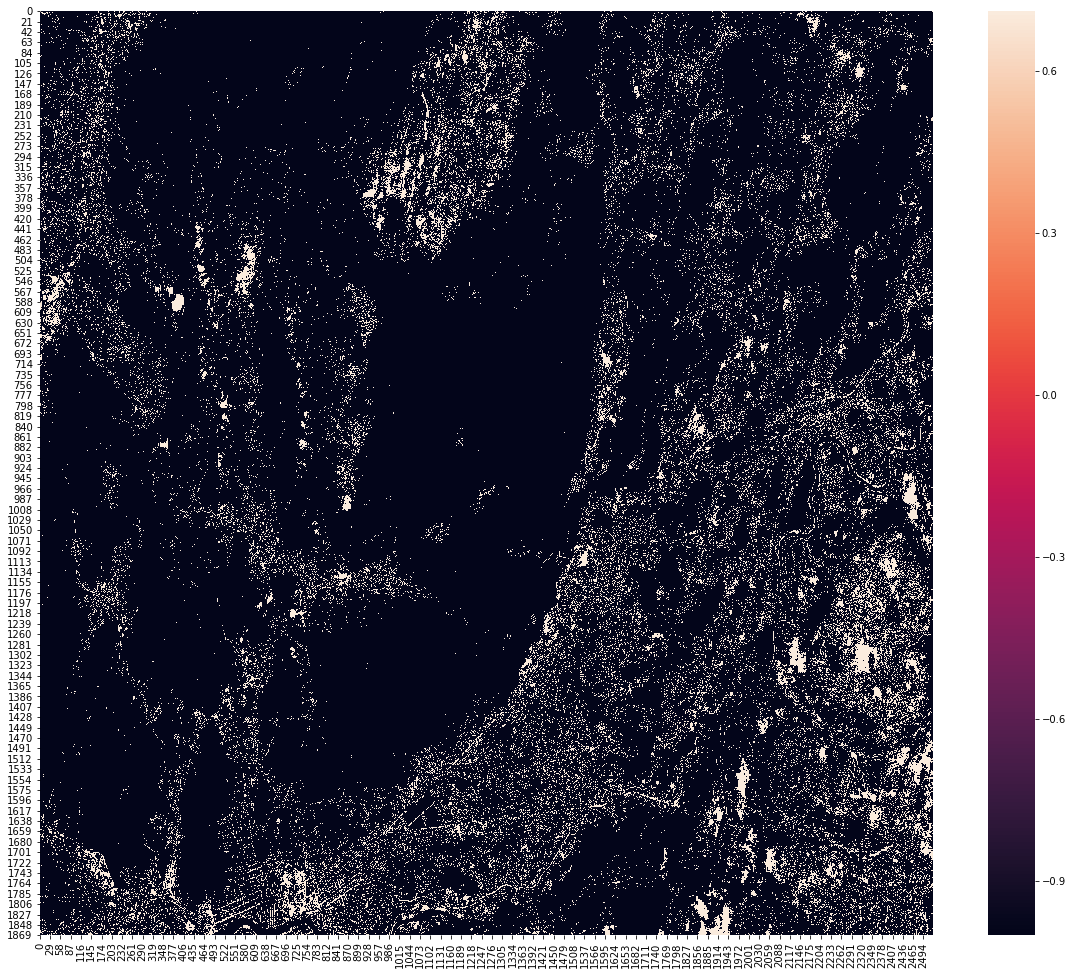

In [47]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
stacked[np.where(stacked > thresh_p)] = 1.
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 0.71
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

In [48]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (13.316919, 2.581680) # niger
coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # west mamprusi, ghana
#coords = (10.097017, -2.439068) #uppere west
#coords = (7.398111, -1.269223) # cocoa
#coords = (7.702058, -0.709011) # brong ahafo bono east
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (-20.147320, -40.837770) # ESPERITO SANTO BR 2
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu-large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (4.179529, -74.889171) # , colombia
#coords = (-1.648663, 30.112521) #rwanda
#coords = (11.574298, -12.492513) # guinea
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.727334, -90.015579) # elsalvador imposible
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (12.398014, -86.963042) # Nicaragua


coords = (coords[1], coords[0])
print(coords)
point = bounding_box(coords, (20*1260)-20, (15*1260)-30, expansion = 0) # -85, +135 el salv
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

(14.2722, 10.596)
[25180.0, 18870.0]


In [49]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/cameroon.tif', 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

# Cloud optimized Geotiff

In [50]:
!gdal_translate ../../ce-hosting/includes/cameroon.tif cameroon.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro cameroon.tif 2 4 8 16 32

Input file size is 2520, 2520
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


# Half-hectare tree density Geotiff

In [35]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.7)
summed += 0.1

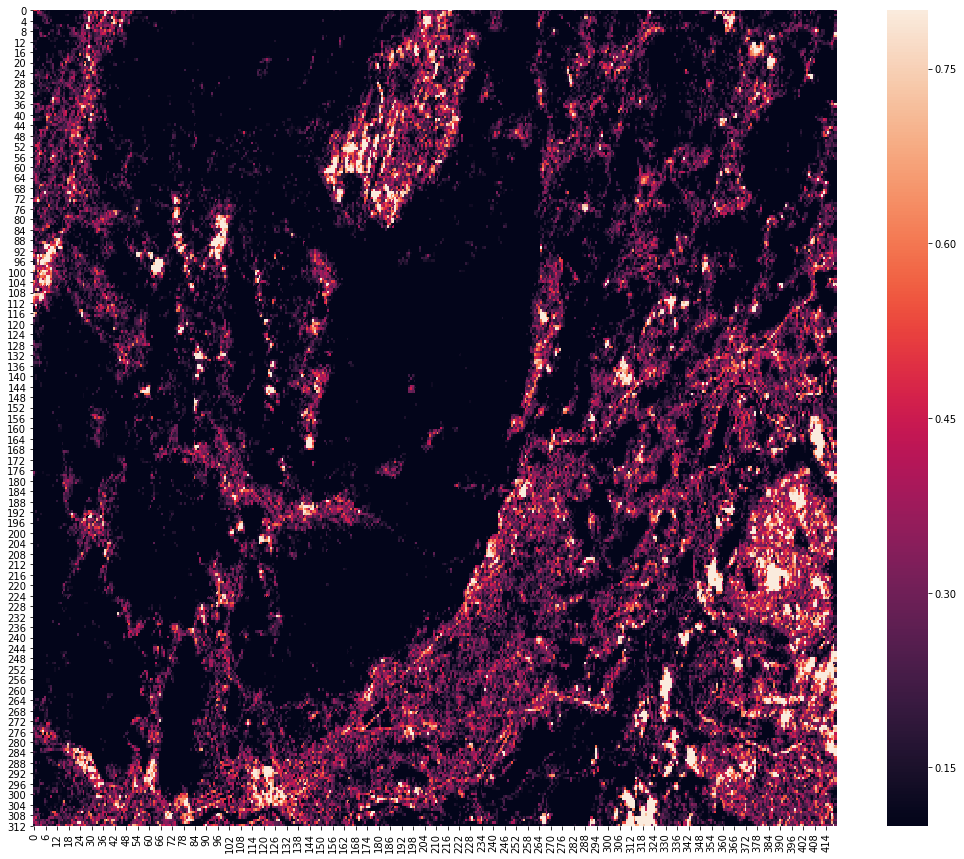

In [36]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)

In [37]:
np.min(summed)

0.1

In [38]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/cameroon1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()